# Généralisation robuste de LDA/QDA

Andrew Wang

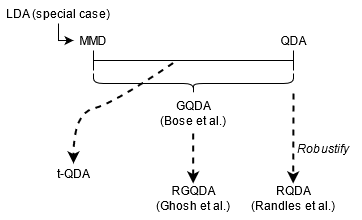

Méthodes classiques: MMD, (LDA,) QDA  
Méthodes génerales: GQDA (qui généralise le regle de classification pour les distributions ES avec la variable c qui interpole entre 0 (MMD) et 1 (QDA))  
Méthodes robustes: RQDA (utilisant le regle QDA mais avec estimation robuste - on peut compter M-estimator, MVE, MCD, S-estimator optimal(selon Croux et al.), etc  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;RGQDA  
Cas particulier: t-QDA (la variable c calculée en termes de DOFs, estimation robuste avec EM)  

QDA avec ES: estimation des parametres avec le meme EM (mais avec E-step fixé) et calculation des posteriors avec le E-step

In [1]:
import numpy as np
import pandas as pd
import random, os, time, csv, warnings, math
from sklearn import metrics, decomposition, discriminant_analysis
from scipy import stats, special, optimize
from sklearn.model_selection import train_test_split
warnings.filterwarnings('ignore') # AMI warning

In [2]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
from preprocess_utils import *
from postprocess_utils import *
from vis import *
from literature_models import *
from fit import *
from femda import *

In [18]:
def run_all(X, y, X_test, y_test, slow=True, percent_outliers=0, conf=False, verbose=True, return_results=False):
    resultats = np.zeros((6,4)) #6 algos, 4 measures
        
    print("LDA")
    ldatest = LDA(method='distributional')
    st = time.time()
    ldatest.fit(X, pd.Series(y))
    resultats[0,0] = time.time()-st
    resultats[0,1:] = print_metrics(pd.Series(y_test), ldatest.predict(X_test, percent_outliers), conf=conf, verbose=verbose, ret=True)
    
    print("QDA")
    qdatest = QDA(method='distributional')
    st = time.time()
    qdatest.fit(X, pd.Series(y))
    resultats[1,0] = time.time()-st    
    resultats[1,1:] = print_metrics(pd.Series(y_test), qdatest.predict(X_test, percent_outliers), conf=conf, verbose=verbose, ret=True)
    
    """
    print("t-LDA")
    t_ldatest = t_LDA(method='distributional')
    t_ldatest.fit(X, pd.Series(y))
    print_metrics(pd.Series(y_test), t_ldatest.predict(X_test, percent_outliers), conf=conf, ret=True)
    """
    
    print("RQDA-MCD")
    rqdamcdtest = RGQDA('MCD')
    st = time.time()
    rqdamcdtest.fit(X, pd.Series(y), c=1)
    resultats[2,0] = time.time()-st 
    resultats[2,1:] = print_metrics(pd.Series(y_test), rqdamcdtest.predict(X_test, percent_outliers), conf=conf, verbose=verbose, ret=True)
    
    print("RGQDA-MCD")
    rgqdamcdtest = RGQDA('MCD')
    st = time.time()
    rgqdamcdtest.fit(X, pd.Series(y))
    resultats[3,0] = time.time()-st 
    resultats[3,1:] = print_metrics(pd.Series(y_test), rgqdamcdtest.predict(X_test, percent_outliers), conf=conf, verbose=verbose, ret=True)   
    
    print("t-QDA")
    t_qdatest = t_QDA(method='distributional')
    st = time.time()
    t_qdatest.fit(X, pd.Series(y))
    resultats[4,0] = time.time()-st  
    resultats[4,1:] = print_metrics(pd.Series(y_test), t_qdatest.predict(X_test, percent_outliers), conf=conf, verbose=verbose, ret=True)
    """
    print("RGQDA-S")
    rgqdastest = RGQDA('S-estimator')
    rgqdastest.fit(X, pd.Series(y))
    print_metrics(pd.Series(y_test), rgqdastest.predict(X_test, percent_outliers))
    print("RQDA-M")
    rqdatest = RGQDA('M-estimator')
    rqdatest.fit(X, pd.Series(y), c=1)
    print_metrics(pd.Series(y_test), rqdatest.predict(X_test, percent_outliers))
    
    print("t-QDA-FEM")
    t_qda_femtest = t_QDA_FEM(method='distributional')
    st = time.time()
    t_qda_femtest.fit(X, pd.Series(y))
    resultats[3,0] = time.time()-st 
    resultats[3,1:] = print_metrics(pd.Series(y_test), t_qda_femtest.predict(X_test, percent_outliers), conf=conf, verbose=verbose, ret=True)

    print("QDA-FEM")
    qda_femtest = QDA_FEM(method='distributional')
    qda_femtest.fit(X, pd.Series(y))
    print_metrics(pd.Series(y_test), qda_femtest.predict(X_test, percent_outliers), conf=conf)
    """
    print("FEMDA with p/trace")
    femda1test = FEMDA()
    femda1test.normalisation_method = 1
    st = time.time()
    femda1test.fit(X, pd.Series(y))
    resultats[5,0] = time.time()-st 
    resultats[5,1:] = print_metrics(pd.Series(y_test), femda1test.predict(X_test, percent_outliers), conf=conf, verbose=verbose, ret=True)
    
    if 1==0 : models= {"LDA": ldatest, "QDA": qdatest, "RGQDA_M": rgqdatest, "RQDA_S": rqdastest, "t_QDA": t_qdatest, "FEMDA1":femda1test}#  #"RGQDA_M": rgqdatest, "RGQDA_S": rgqdastest, "RQDA_M": rqdatest, "RQDA_S": rqdastest,
    models= {"LDA": ldatest, "QDA": qdatest, "RQDA-MCD": rqdamcdtest, "RGQDA-MCD": rgqdamcdtest, "t_QDA": t_qdatest, "FEMDA1":femda1test} #
    
    if return_results:
        return models, resultats
    else:
        return models

In [6]:
def test_all(models, X_test, y_test, percent_outliers=0):
    models = models if type(models) is not dict else list(models.values())
    
    for model in models:
        print(type(model).__name__)
        print_metrics(pd.Series(y_test), model.predict(X_test, percent_outliers=percent_outliers), conf=False)

## Fashion-MNIST

### Import MNIST data

In [14]:
np.random.seed(44)
random.seed(44)
read_mnist_train = pd.read_csv(r"..\data\fashion-mnist_train.csv")
read_mnist_test = pd.read_csv(r"..\data\fashion-mnist_test.csv")
mnist_labels_raw = read_mnist_train.iloc[:, 0]
mnist_data = read_mnist_train.iloc[:, 1:]
mnist_test_labels_raw = read_mnist_test.iloc[:, 0]
mnist_test_data = read_mnist_test.iloc[:, 1:]

In [15]:
selected_digits = [0,1,2,3,4,5,6,7,8,9]
mnist_pca, mnist_labels, mnist_raw, ve, pca = import_subset(mnist_data, mnist_labels_raw, selected_digits,30, 800)
mnist_test_pca, mnist_test_labels, mnist_test_raw,_,_2 = import_subset(mnist_test_data, mnist_test_labels_raw, selected_digits, 30, 400, pca=pca)
#plot_fashion_mnist(mnist_pca, mnist_labels, "MNIST_UMAP_0279.png")

### Run full experiment

In [21]:
result_book_MNIST4 = np.zeros((6,4,10)) #6 algos, 4 measures, 10 runs
result_book_MNIST_n = np.zeros((6,4,10))

for i in range(10):
    #Sample and PCA
    selected_digits = [0,1,2,3,4,5,6,7,8,9]
    mnist_pca, mnist_labels, mnist_raw, ve, pca = import_subset(mnist_data, mnist_labels_raw, selected_digits,30, 800)
    mnist_test_pca, mnist_test_labels, mnist_test_raw,_,_2 = import_subset(mnist_test_data, mnist_test_labels_raw, selected_digits, 30, 400, pca=pca)
    
    #Contaminate
    mnist_labels_mislabelled = mislabelled(800, 0.1, np.unique(mnist_labels))
    mnist_pca_contaminated,_ = contaminate_dataset(mnist_pca, 1)
    mnist_test_pca_c, contam_ind = contaminate_dataset(mnist_test_pca, 1)
    
    #Run models (outlier rejection: change percent_outliers)
    models, result_book_MNIST4[:,:,i] = run_all(mnist_pca_contaminated, mnist_labels_mislabelled, mnist_test_pca_c, mnist_test_labels, percent_outliers=0, conf=False, verbose=True, return_results=True)
    
    #test on normalisation
    #mnist_pca_n = normalise_centered(mnist_pca_contaminated, mnist_labels_mislabelled)
    #models_n, result_book_MNIST_n[:,:,i] = run_all(mnist_pca_n, mnist_labels_mislabelled, mnist_test_pca_c, mnist_test_labels, conf=False, verbose=True, return_results=True)

LDA
N 4000 Accuracy 0.677 ARI 0.41 AMI 0.56236
QDA
N 4000 Accuracy 0.63875 ARI 0.37507 AMI 0.52181
RQDA-MCD
estimating...
estimating...
estimating...
estimating...
estimating...
estimating...
estimating...
estimating...
estimating...
estimating...
N 4000 Accuracy 0.19775 ARI 0.07564 AMI 0.16184
RGQDA-MCD
estimating...
estimating...
estimating...
estimating...
estimating...
estimating...
estimating...
estimating...
estimating...
estimating...
optimal c is 0.013323097057090267
N 4000 Accuracy 0.198 ARI 0.07526 AMI 0.16021
t-QDA
N 4000 Accuracy 0.7925 ARI 0.62169 AMI 0.68487
FEMDA with p/trace
N 4000 Accuracy 0.794 ARI 0.62532 AMI 0.69291
LDA
N 4000 Accuracy 0.676 ARI 0.39959 AMI 0.55483
QDA
N 4000 Accuracy 0.63625 ARI 0.36066 AMI 0.51746
RQDA-MCD
estimating...
estimating...
estimating...
estimating...
estimating...
estimating...
estimating...
estimating...
estimating...
estimating...
N 4000 Accuracy 0.1 ARI 0.0 AMI 0.0
RGQDA-MCD
estimating...
estimating...
estimating...
estimating...
est

In [22]:
%store result_book_MNIST4

Stored 'result_book_MNIST4' (ndarray)


In [20]:
%store result_book_MNIST3

Stored 'result_book_MNIST3' (ndarray)


In [14]:
%store result_book_MNIST

Stored 'result_book_MNIST' (ndarray)


In [ ]:
%store result_book_MNIST2

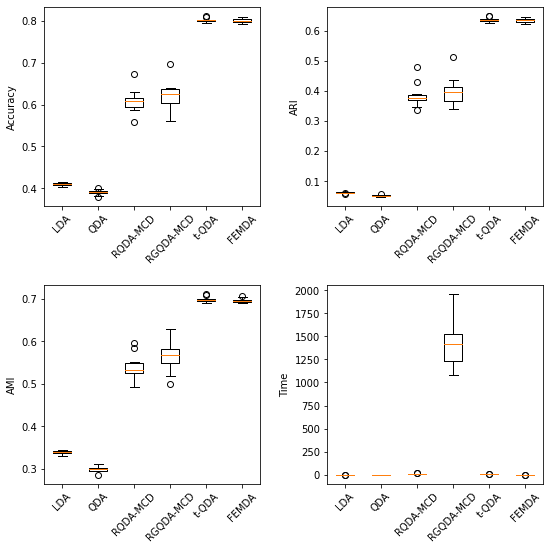

In [125]:
fig,extents=box_plot(result_book_MNIST3, algos=["LDA","QDA","RQDA-MCD","RGQDA-MCD","t-QDA", "FEMDA"], measures=["Time", "Accuracy", "ARI", "AMI"])

In [126]:
save_subplots('results_MNIST_50', fig, extents, ext='pdf')

## Synthetic Data setup 1

In [6]:
np.random.seed(seed=233423)

In [7]:
means_synth1 = {0: [1, 1, 1, 1, 1, 1 ], 1: [-1,-1,-1, 1, 1, 1], 2: [1, 1, 1, -1,-1,-1], 3: [-1,-1,-1,-1,-1,-1]}
covs_synth1 = {0: np.eye(6), 1: np.eye(6), 2: np.eye(6), 3: np.eye(6)}

In [8]:
def synthesise(n, contamination=0, mislabelling=0): #contamination, mislabelling percent
    hard = False
    X1,o1 = contaminated(n, stats.multivariate_t, contamination, loc=means_synth1[0], shape=covs_synth1[0], df=1, hard=hard) #cauchy
    X2,o2 = contaminated(n, stats.multivariate_t, contamination, loc=means_synth1[1], shape=covs_synth1[1], df=3, hard=hard) #t
    X3,o3 = contaminated(n, stats.multivariate_t, contamination, loc=means_synth1[2], shape=covs_synth1[2], df=20, hard=hard) #normal
    X4,o4 = contaminated(n, stats.multivariate_t, contamination, loc=means_synth1[3], shape=covs_synth1[3], df=1, hard=hard) #cauchy
    y =  mislabelled(n, mislabelling, np.arange(4))
    return np.vstack([X1, X2, X3, X4]), y, apply_outlierness([o1,o2,o3,o4],y)

In [9]:
X_test,_,y_test = synthesise(1000)

### Synthetic data pure

In [11]:
X,y,_ = synthesise(1000, contamination=0, mislabelling=0)

LDA
Fitting time 0.01566028594970703
N 4000 Accuracy 0.648 ARI 0.31637 AMI 0.33118
QDA
Fitting time 0.0
N 4000 Accuracy 0.54575 ARI 0.28166 AMI 0.32733
t-LDA
Fitting time 1.027367353439331
N 4000 Accuracy 0.82875 ARI 0.60506 AMI 0.56191
t-QDA
Fitting time 1.0023939609527588
N 4000 Accuracy 0.82775 ARI 0.60295 AMI 0.55957
t-QDA-FEM
Fitting time 0.11555171012878418
N 4000 Accuracy 0.8275 ARI 0.60179 AMI 0.55889
QDA-FEM
Fitting time 0.08469796180725098
N 4000 Accuracy 0.81525 ARI 0.57076 AMI 0.54864
FEMDA
Fitting time 0.06902575492858887
N 4000 Accuracy 0.75625 ARI 0.43781 AMI 0.49124
FEMDA with naive scatter constant
Fitting time 0.0846397876739502
N 4000 Accuracy 0.7535 ARI 0.46551 AMI 0.48158
FEMDA test
Fitting time 0.0781257152557373
N 4000 Accuracy 0.754 ARI 0.45916 AMI 0.47037


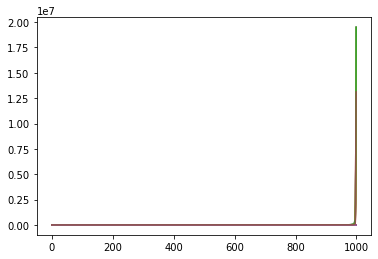

In [38]:
models_synth_pure = run_all(X,y,X_test,y_test)

### Synthetic data with mislabelling

In [39]:
X,y ,_= synthesise(1000, contamination=0, mislabelling=0.1)

LDA
Fitting time 0.0
N 4000 Accuracy 0.574 ARI 0.27149 AMI 0.2817
QDA
Fitting time 0.0
N 4000 Accuracy 0.53575 ARI 0.255 AMI 0.29496
t-LDA
Fitting time 0.7018258571624756
N 4000 Accuracy 0.825 ARI 0.597 AMI 0.55203
t-QDA
Fitting time 0.8644437789916992
N 4000 Accuracy 0.82275 ARI 0.59282 AMI 0.54841
t-QDA-FEM
Fitting time 1.6672170162200928
N 4000 Accuracy 0.82225 ARI 0.59171 AMI 0.55084
QDA-FEM
Fitting time 0.06250119209289551
N 4000 Accuracy 0.8095 ARI 0.55874 AMI 0.54177
FEMDA
Fitting time 0.06900858879089355
N 4000 Accuracy 0.73475 ARI 0.43842 AMI 0.47313
FEMDA with naive scatter constant
Fitting time 0.07812738418579102
N 4000 Accuracy 0.80525 ARI 0.55163 AMI 0.51646
FEMDA test
Fitting time 0.11588835716247559
N 4000 Accuracy 0.78975 ARI 0.51658 AMI 0.49998


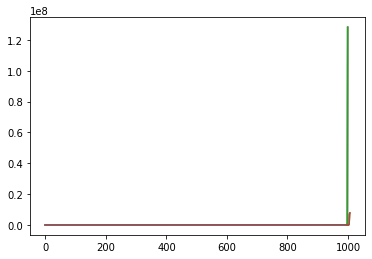

In [40]:
models_synth_mislabelling = run_all(X,y,X_test,y_test)

### Synthetic data with contamination

In [41]:
X,y,_ = synthesise(1000, contamination=0.1, mislabelling=0)

LDA
Fitting time 0.022196531295776367
N 4000 Accuracy 0.74775 ARI 0.45067 AMI 0.41667
QDA
Fitting time 0.0
N 4000 Accuracy 0.54 ARI 0.27131 AMI 0.3148
t-LDA
Fitting time 0.8214848041534424
N 4000 Accuracy 0.827 ARI 0.60031 AMI 0.55534
t-QDA
Fitting time 0.7172982692718506
N 4000 Accuracy 0.82425 ARI 0.59558 AMI 0.55183
t-QDA-FEM
Fitting time 0.11589407920837402
N 4000 Accuracy 0.8265 ARI 0.59852 AMI 0.55548
QDA-FEM
Fitting time 0.1002645492553711
N 4000 Accuracy 0.807 ARI 0.55175 AMI 0.53401
FEMDA
Fitting time 0.07811808586120605
N 4000 Accuracy 0.72375 ARI 0.42813 AMI 0.45673
FEMDA with naive scatter constant
Fitting time 0.08460783958435059
N 4000 Accuracy 0.76525 ARI 0.47897 AMI 0.47665
FEMDA test
Fitting time 0.06899023056030273
N 4000 Accuracy 0.7615 ARI 0.4546 AMI 0.49054


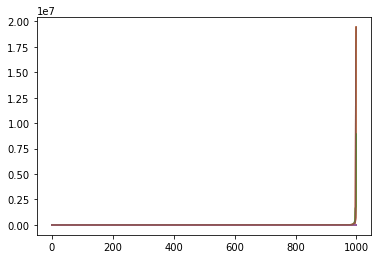

In [42]:
models_synth_contamination = run_all(X,y,X_test,y_test)

### Synthetic data with contamination and mislabelling

In [43]:
X,y,_ = synthesise(1000, contamination=0.1, mislabelling=0.1)

LDA
Fitting time 0.015624284744262695
N 4000 Accuracy 0.66725 ARI 0.31741 AMI 0.30057
QDA
Fitting time 0.0
N 4000 Accuracy 0.4365 ARI 0.09463 AMI 0.16086
t-LDA
Fitting time 0.6481053829193115
N 4000 Accuracy 0.823 ARI 0.59239 AMI 0.54568
t-QDA
Fitting time 0.6706089973449707
N 4000 Accuracy 0.82025 ARI 0.58799 AMI 0.54326
t-QDA-FEM
Fitting time 0.12243247032165527
N 4000 Accuracy 0.8225 ARI 0.59173 AMI 0.54789
QDA-FEM
Fitting time 0.10023856163024902
N 4000 Accuracy 0.809 ARI 0.55915 AMI 0.53948
FEMDA
Fitting time 0.06906366348266602
N 4000 Accuracy 0.74425 ARI 0.4526 AMI 0.45973
FEMDA with naive scatter constant
Fitting time 0.15355134010314941
N 4000 Accuracy 0.64475 ARI 0.30075 AMI 0.40237
FEMDA test
Fitting time 0.06901049613952637
N 4000 Accuracy 0.783 ARI 0.5078 AMI 0.50494


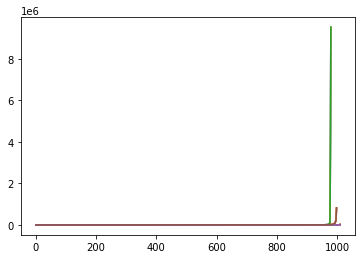

In [44]:
models_synth_contamination_mislabelling = run_all(X,y,X_test,y_test)

In [45]:
for c in models_synth_contamination_mislabelling["t_QDA"].covariances:
    print(np.trace(c))

7.181722448181917
6.879997839231134
6.500315149805343
7.427699533651744


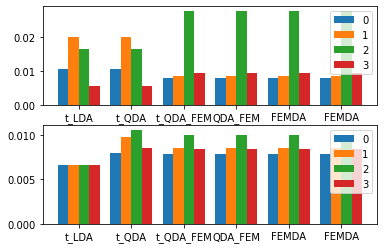

In [46]:
evaluate_all(list(models_synth_contamination_mislabelling.values())[2:], means_synth1, covs_synth1)

### Synthetic data with test contamination

In [47]:
X_test_c,y_test_c_clean,y_test_c = synthesise(1000, contamination=0.1, mislabelling=0)

In [48]:
print("With outlier rejection")
test_all(models_synth_contamination_mislabelling,X_test_c,y_test_c, percent_outliers=0.1)

With outlier rejection
LDA
N 4000 Accuracy 0.662 ARI 0.30099 AMI 0.28997
QDA
N 4000 Accuracy 0.44525 ARI 0.11129 AMI 0.15164
t_LDA
N 4000 Accuracy 0.786 ARI 0.52146 AMI 0.46437
t_QDA
N 4000 Accuracy 0.78475 ARI 0.51668 AMI 0.46035
t_QDA_FEM
N 4000 Accuracy 0.7845 ARI 0.51464 AMI 0.46118
QDA_FEM
N 4000 Accuracy 0.74925 ARI 0.44224 AMI 0.42606
FEMDA
N 4000 Accuracy 0.783 ARI 0.49078 AMI 0.46234
FEMDA
N 4000 Accuracy 0.76475 ARI 0.48068 AMI 0.44614


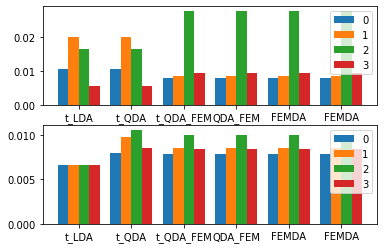

In [49]:
evaluate_all(list(models_synth_contamination_mislabelling.values())[2:], means_synth1, covs_synth1)

In [50]:
print("Without outlier rejection")
test_all(models_synth_contamination_mislabelling,X_test_c,y_test_c_clean, percent_outliers=0)

Without outlier rejection
LDA
N 4000 Accuracy 0.65225 ARI 0.29559 AMI 0.27895
QDA
N 4000 Accuracy 0.43 ARI 0.08617 AMI 0.13482
t_LDA
N 4000 Accuracy 0.80625 ARI 0.55725 AMI 0.51035
t_QDA
N 4000 Accuracy 0.8035 ARI 0.55195 AMI 0.50596
t_QDA_FEM
N 4000 Accuracy 0.805 ARI 0.55334 AMI 0.50978
QDA_FEM
N 4000 Accuracy 0.78275 ARI 0.50048 AMI 0.49657
FEMDA
N 4000 Accuracy 0.713 ARI 0.4128 AMI 0.41889
FEMDA
N 4000 Accuracy 0.77125 ARI 0.486 AMI 0.47328


#### Pre-Normalised data with test contamination

In [51]:
X_n = normalise_centered(X, y)

With outlier rejection
LDA
Fitting time 0.015607595443725586
N 4000 Accuracy 0.7715 ARI 0.49725 AMI 0.4552
QDA
Fitting time 0.0
N 4000 Accuracy 0.77225 ARI 0.49753 AMI 0.4555
t-LDA
Fitting time 1.1870744228363037
N 4000 Accuracy 0.776 ARI 0.50029 AMI 0.45771
t-QDA
Fitting time 1.171898365020752
N 4000 Accuracy 0.77675 ARI 0.50105 AMI 0.45814
t-QDA-FEM
Fitting time 1.1028680801391602
N 4000 Accuracy 0.777 ARI 0.50073 AMI 0.45717
QDA-FEM
Fitting time 0.0805971622467041
N 4000 Accuracy 0.77275 ARI 0.49719 AMI 0.45496
FEMDA
Fitting time 0.06850934028625488
N 4000 Accuracy 0.759 ARI 0.47049 AMI 0.44275
FEMDA with naive scatter constant
Fitting time 0.13941693305969238
N 4000 Accuracy 0.77475 ARI 0.45849 AMI 0.44997
FEMDA test
Fitting time 0.06905364990234375
N 4000 Accuracy 0.74625 ARI 0.44687 AMI 0.43469


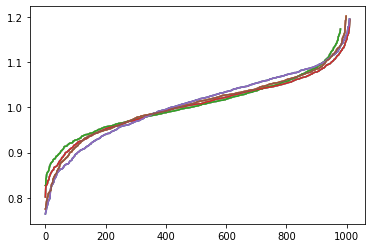

In [52]:
print("With outlier rejection")
models_synth_mislabelling_contamination_n = run_all(X_n,y,X_test_c,y_test_c, percent_outliers=0.1)

In [53]:
print("Without outlier rejection")
test_all(models_synth_mislabelling_contamination_n,X_test_c,y_test_c_clean, percent_outliers=0)

Without outlier rejection
LDA
N 4000 Accuracy 0.78175 ARI 0.51097 AMI 0.47664
QDA
N 4000 Accuracy 0.783 ARI 0.51309 AMI 0.47744
t_LDA
N 4000 Accuracy 0.78075 ARI 0.50859 AMI 0.47136
t_QDA
N 4000 Accuracy 0.78175 ARI 0.51027 AMI 0.47218
t_QDA_FEM
N 4000 Accuracy 0.78125 ARI 0.50931 AMI 0.47085
QDA_FEM
N 4000 Accuracy 0.7825 ARI 0.5122 AMI 0.47632
FEMDA
N 4000 Accuracy 0.754 ARI 0.46187 AMI 0.45023
FEMDA
N 4000 Accuracy 0.66825 ARI 0.34342 AMI 0.41841


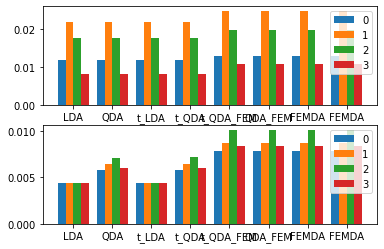

In [54]:
evaluate_all(models_synth_mislabelling_contamination_n, means_synth1, covs_synth1)

## Synthetic data setup 2 (for visualisation)

In [55]:
means_synth2 = {0: np.array([2 , 2]), 1: np.array([-2, 2]), 2: np.array([2 ,-2]), 3: np.array([-2,-2]), 4: np.array([2 , 6])}
covs_synth2 = {0: np.eye(2), 1: np.eye(2), 2: np.eye(2), 3: np.eye(2), 4: np.eye(2)}

In [56]:
def synthesise2d(n, contamination=0, mislabelling=0): #contamination, mislabelling percent
    hard = False
    X1,o1 = contaminated(n, stats.multivariate_t, contamination, loc=means_synth2[0], shape=covs_synth2[0], df=1, hard=hard) #cauchy
    X2,o2 = contaminated(n, stats.multivariate_t, contamination, loc=means_synth2[1], shape=covs_synth2[1], df=3, hard=hard) #t
    X3,o3 = contaminated(n, stats.multivariate_t, contamination, loc=means_synth2[2], shape=covs_synth2[2], df=20, hard=hard) #normal
    X4,o4 = contaminated(n, stats.multivariate_t, contamination, loc=means_synth2[3], shape=covs_synth2[3], df=1, hard=hard) #cauchy
    X5,o5 = contaminated(n, stats.multivariate_t, contamination, loc=means_synth2[4], shape=covs_synth2[4], df=1, hard=hard) #cauchy
    y = mislabelled(n, mislabelling, np.arange(5))
    return np.vstack([X1, X2, X3, X4, X5]), y, apply_outlierness([o1,o2,o3,o4,o5], y)

In [57]:
X_test_2d,_,y_test_2d = synthesise2d(100)

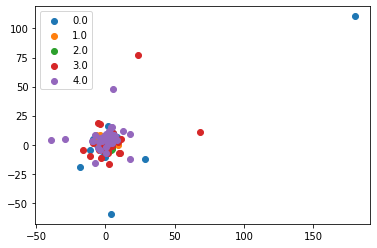

In [58]:
ax = plt.figure().gca()
#plt.xlim([-10,10]); plt.ylim([-10,10])
plot_dataset(X_test_2d, y_test_2d, ax)
plt.legend()

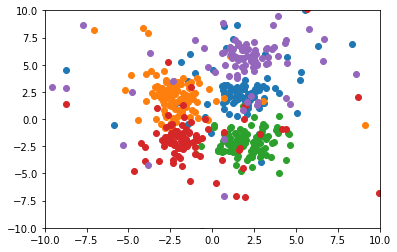

In [59]:
ax = plt.figure().gca()
plt.xlim([-10,10]); plt.ylim([-10,10])
plot_dataset(X_test_2d, y_test_2d, ax)

### Pure dataset

In [60]:
X_2d,y_2d,_ = synthesise2d(100, contamination=0, mislabelling=0)

LDA
Fitting time 0.0
N 500 Accuracy 0.614 ARI 0.36351 AMI 0.40325
QDA
Fitting time 0.0
N 500 Accuracy 0.534 ARI 0.31532 AMI 0.36414
t-LDA
Fitting time 0.5169827938079834
N 500 Accuracy 0.796 ARI 0.56752 AMI 0.5499
t-QDA
Fitting time 0.5009753704071045
N 500 Accuracy 0.788 ARI 0.54877 AMI 0.53362
t-QDA-FEM
Fitting time 0.1003108024597168
N 500 Accuracy 0.788 ARI 0.54886 AMI 0.53118
QDA-FEM
Fitting time 0.04686903953552246
N 500 Accuracy 0.768 ARI 0.51008 AMI 0.50348
FEMDA
Fitting time 0.06900835037231445
N 500 Accuracy 0.786 ARI 0.54468 AMI 0.53842
FEMDA with naive scatter constant
Fitting time 0.053401947021484375
N 500 Accuracy 0.752 ARI 0.47941 AMI 0.50206
FEMDA test
Fitting time 0.04686927795410156
N 500 Accuracy 0.626 ARI 0.32578 AMI 0.40483


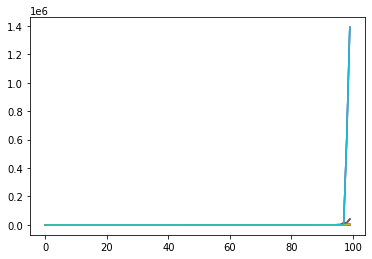

In [61]:
models_vis_pure = run_all(X_2d,y_2d,X_test_2d,y_test_2d)

approx_tQDA_test_pure = t_QDA(method='generalised')
approx_tQDA_test_pure.fit(X_2d, pd.Series(y_2d))
print_metrics(pd.Series(y_test_2d), approx_tQDA_test_pure.predict(X_test_2d))

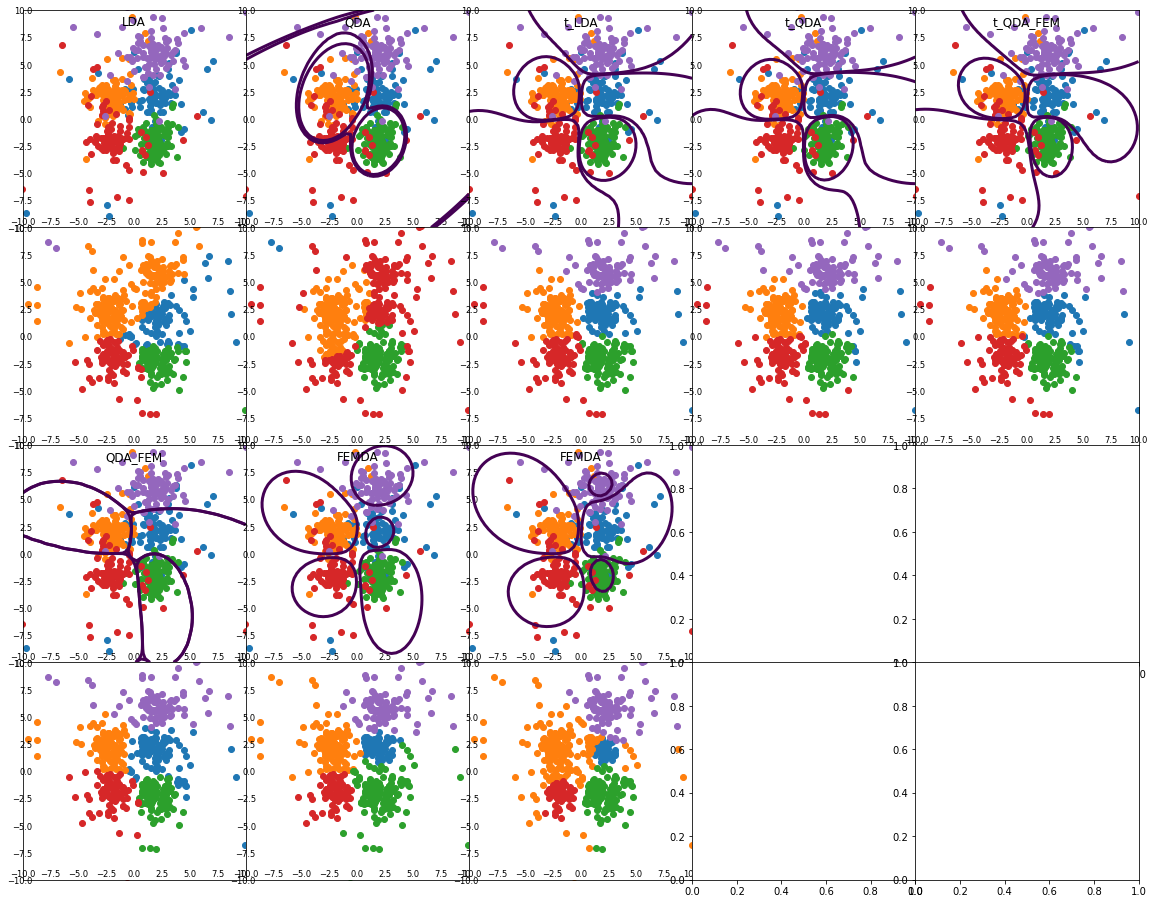

In [62]:
plot_models(X_2d, y_2d, X_test_2d, models_vis_pure)#+(approx_tQDA_test_pure,))

### Dataset with mislabelling

In [63]:
X_2d,y_2d,_ = synthesise2d(100, contamination=0, mislabelling=0.1)

LDA
Fitting time 0.0
N 500 Accuracy 0.77 ARI 0.52374 AMI 0.51854
QDA
Fitting time 0.0
N 500 Accuracy 0.576 ARI 0.37795 AMI 0.40989
t-LDA
Fitting time 0.4701411724090576
N 500 Accuracy 0.8 ARI 0.57406 AMI 0.55593
t-QDA
Fitting time 0.48543620109558105
N 500 Accuracy 0.794 ARI 0.56371 AMI 0.54331
t-QDA-FEM
Fitting time 0.11591529846191406
N 500 Accuracy 0.78 ARI 0.53692 AMI 0.52356
QDA-FEM
Fitting time 0.06247663497924805
N 500 Accuracy 0.778 ARI 0.53428 AMI 0.52414
FEMDA
Fitting time 0.05338644981384277
N 500 Accuracy 0.778 ARI 0.53297 AMI 0.52522
FEMDA with naive scatter constant
Fitting time 0.031243324279785156
N 500 Accuracy 0.778 ARI 0.53249 AMI 0.51812
FEMDA test
Fitting time 0.03125357627868652
N 500 Accuracy 0.772 ARI 0.52286 AMI 0.52195


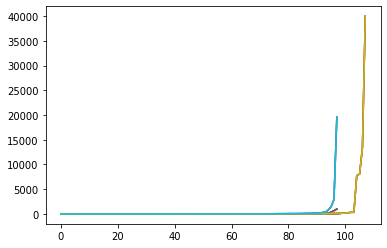

In [64]:
models_vis_mislabelling = run_all(X_2d,y_2d,X_test_2d,y_test_2d)

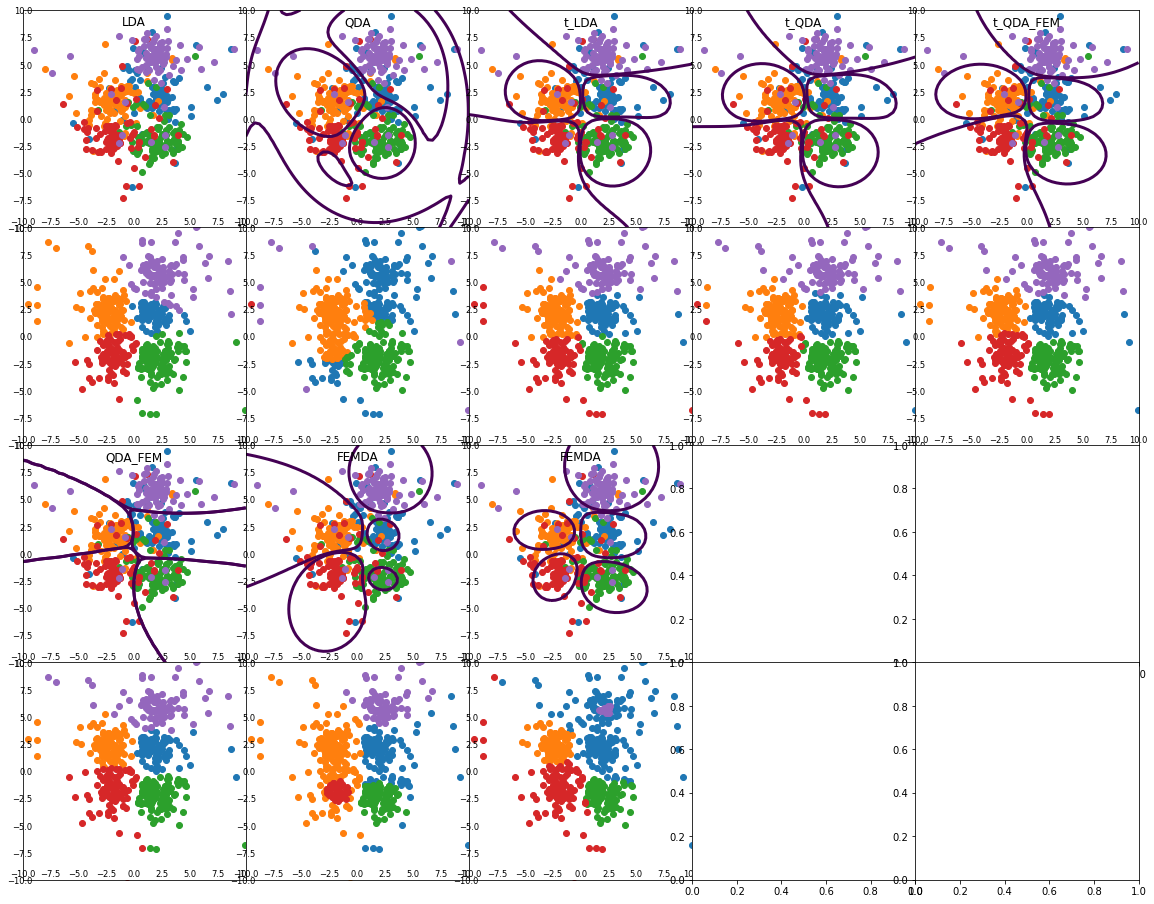

In [65]:
plot_models(X_2d, y_2d, X_test_2d, models_vis_mislabelling)#+(approx_tQDA_test_mislabelling,))

### Dataset with contamination

In [66]:
X_2d,y_2d,_ = synthesise2d(100, contamination=0.1, mislabelling=0)

LDA
Fitting time 0.0
N 500 Accuracy 0.748 ARI 0.48108 AMI 0.47488
QDA
Fitting time 0.015624523162841797
N 500 Accuracy 0.638 ARI 0.42582 AMI 0.4549
t-LDA
Fitting time 0.5390632152557373
N 500 Accuracy 0.796 ARI 0.56628 AMI 0.54593
t-QDA
Fitting time 0.5325372219085693
N 500 Accuracy 0.79 ARI 0.55732 AMI 0.54012
t-QDA-FEM
Fitting time 0.1380290985107422
N 500 Accuracy 0.79 ARI 0.55184 AMI 0.53773
QDA-FEM
Fitting time 0.062494516372680664
N 500 Accuracy 0.778 ARI 0.52711 AMI 0.52152
FEMDA
Fitting time 0.07813191413879395
N 500 Accuracy 0.78 ARI 0.53953 AMI 0.53116
FEMDA with naive scatter constant
Fitting time 0.05338859558105469
N 500 Accuracy 0.606 ARI 0.28249 AMI 0.41878
FEMDA test
Fitting time 0.06901121139526367
N 500 Accuracy 0.762 ARI 0.4985 AMI 0.50314


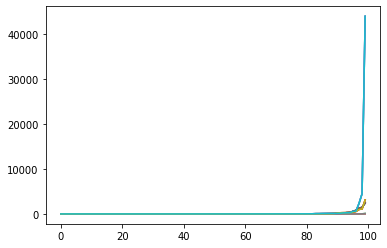

In [67]:
models_vis_contamination = run_all(X_2d,y_2d,X_test_2d,y_test_2d)

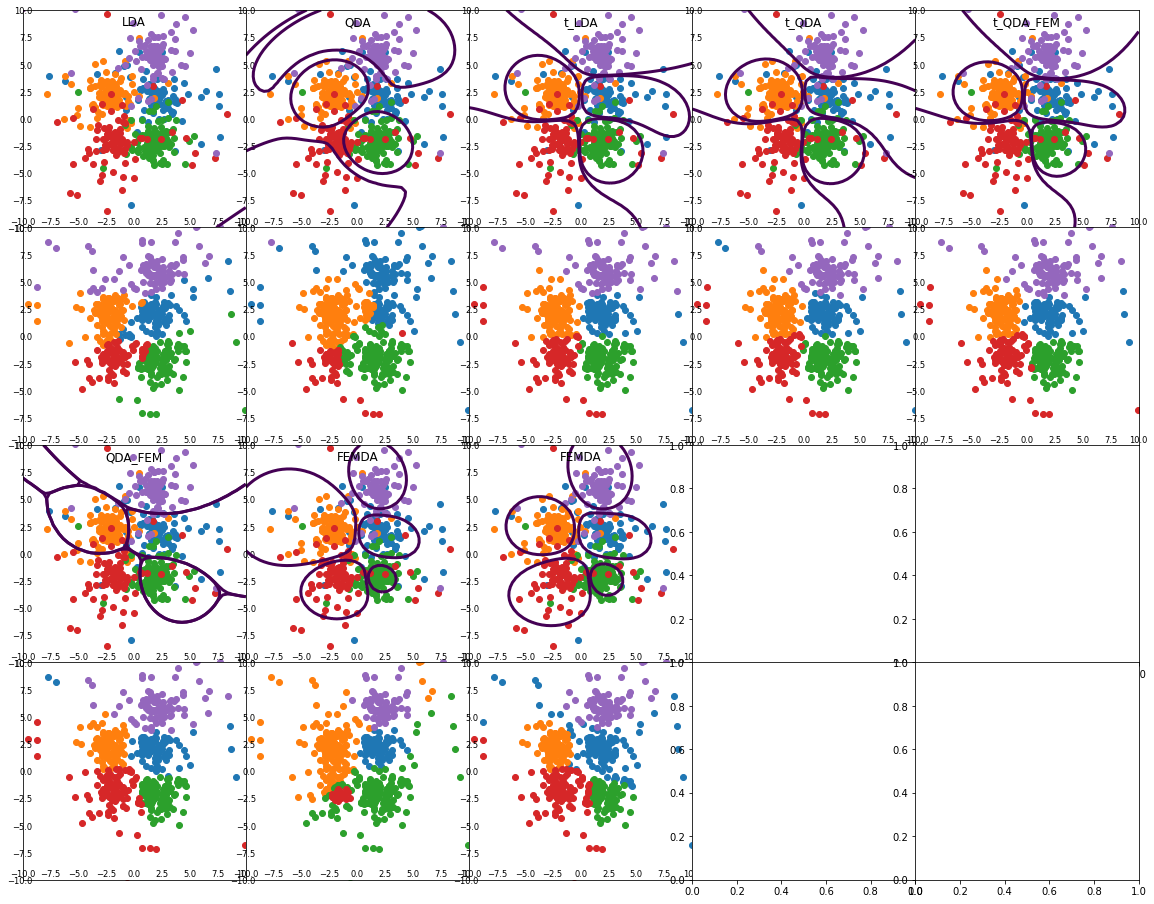

In [68]:
plot_models(X_2d, y_2d, X_test_2d, models_vis_contamination)#+(approx_tQDA_test_contamination,))

### Dataset with mislabelling and contamination

In [69]:
X_2d,y_2d,_ = synthesise2d(100, contamination=0.1, mislabelling=0.1)

LDA
Fitting time 0.0
N 500 Accuracy 0.51 ARI 0.24383 AMI 0.3013
QDA
Fitting time 0.01564502716064453
N 500 Accuracy 0.542 ARI 0.25568 AMI 0.31412
t-LDA
Fitting time 0.37891674041748047
N 500 Accuracy 0.79 ARI 0.5568 AMI 0.5384
t-QDA
Fitting time 0.40105152130126953
N 500 Accuracy 0.782 ARI 0.54338 AMI 0.52825
t-QDA-FEM
Fitting time 0.11590194702148438
N 500 Accuracy 0.76 ARI 0.49848 AMI 0.49214
QDA-FEM
Fitting time 0.06248974800109863
N 500 Accuracy 0.754 ARI 0.47854 AMI 0.49734
FEMDA
Fitting time 0.05338692665100098
N 500 Accuracy 0.684 ARI 0.47443 AMI 0.5011
FEMDA with naive scatter constant
Fitting time 0.05338168144226074
N 500 Accuracy 0.708 ARI 0.41195 AMI 0.4688
FEMDA test
Fitting time 0.06251764297485352
N 500 Accuracy 0.726 ARI 0.42119 AMI 0.47256


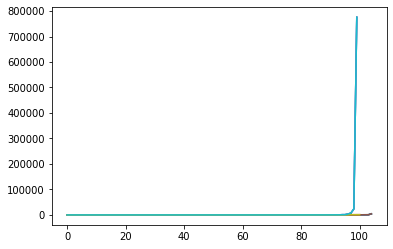

In [70]:
models_vis_mislabelling_contamination = run_all(X_2d,y_2d,X_test_2d,y_test_2d)

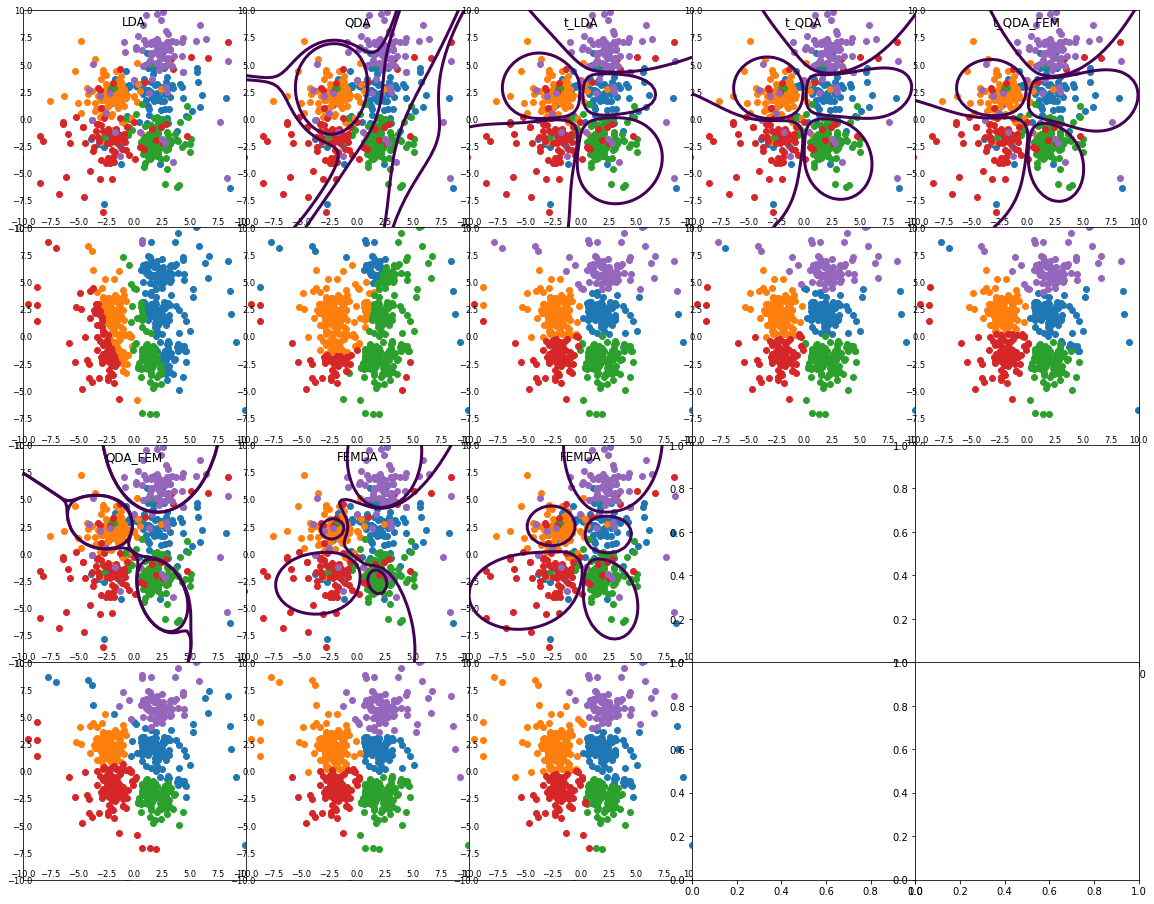

In [71]:
plot_models(X_2d, y_2d, X_test_2d, models_vis_mislabelling_contamination)#+(approx_tQDA_test_mislabelling_contamination,))

### Dataset with test contamination

In [72]:
X_test_c_2d,y_test_c_2d_clean,y_test_c_2d = synthesise2d(100, contamination=0.1)

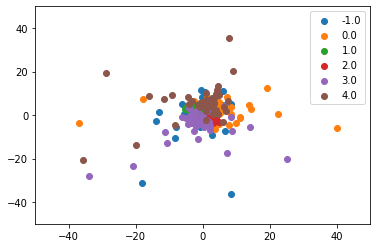

In [73]:
ax = plt.figure().gca()
plt.xlim([-50,50]); plt.ylim([-50,50])
plot_dataset(X_test_c_2d, y_test_c_2d, ax)
plt.legend()

In [74]:
print("With outlier rejection")
test_all(models_vis_mislabelling_contamination,X_test_c_2d,y_test_c_2d, percent_outliers=0.1)

With outlier rejection
LDA
N 500 Accuracy 0.492 ARI 0.21263 AMI 0.27262
QDA
N 500 Accuracy 0.522 ARI 0.25636 AMI 0.31341
t_LDA
N 500 Accuracy 0.732 ARI 0.47225 AMI 0.45465
t_QDA
N 500 Accuracy 0.734 ARI 0.47388 AMI 0.45598
t_QDA_FEM
N 500 Accuracy 0.726 ARI 0.45929 AMI 0.44838
QDA_FEM
N 500 Accuracy 0.704 ARI 0.41682 AMI 0.43072
FEMDA
N 500 Accuracy 0.636 ARI 0.33077 AMI 0.38699
FEMDA
N 500 Accuracy 0.682 ARI 0.37065 AMI 0.38044


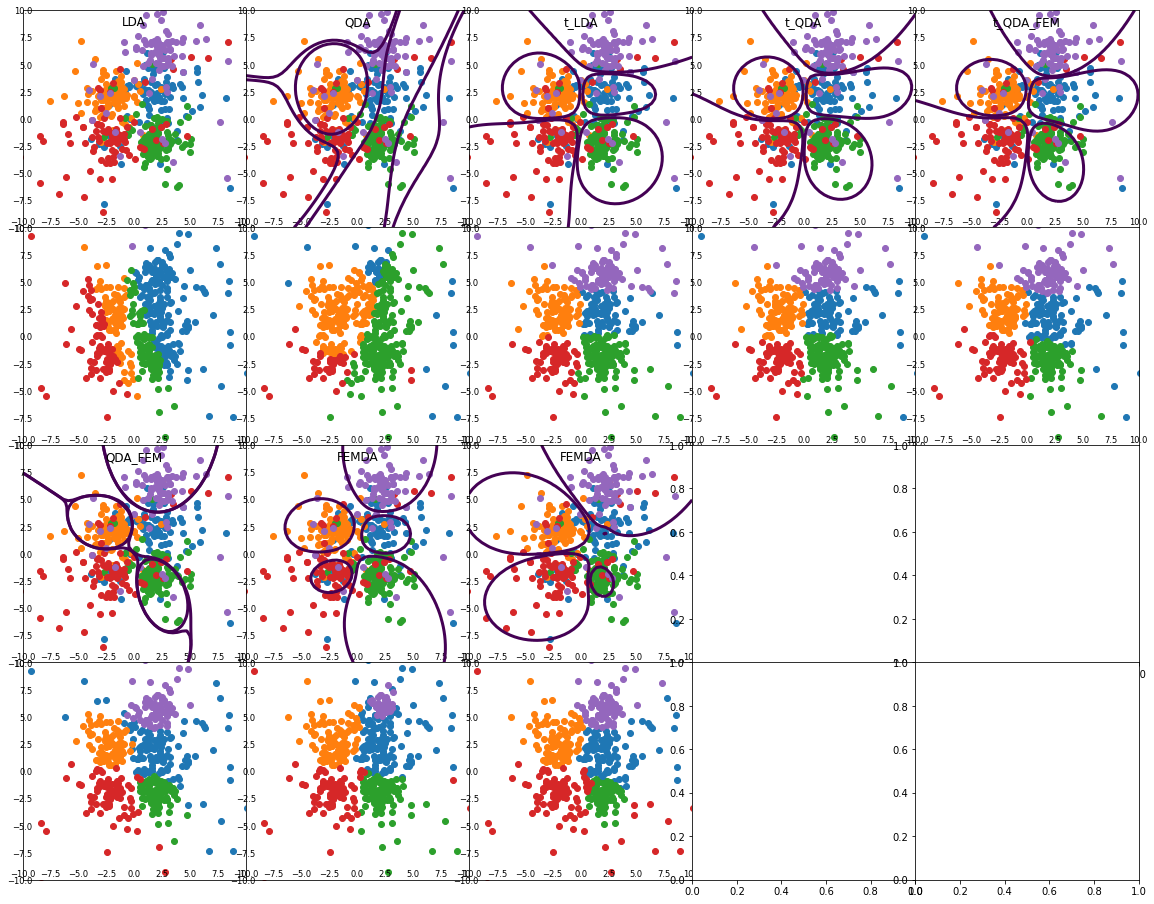

In [75]:
plot_models(X_2d, y_2d, X_test_c_2d, models_vis_mislabelling_contamination)

In [76]:
print("Without outlier rejection")
test_all(models_vis_mislabelling_contamination,X_test_c_2d,y_test_c_2d_clean, percent_outliers=0)

Without outlier rejection
LDA
N 500 Accuracy 0.506 ARI 0.20935 AMI 0.25695
QDA
N 500 Accuracy 0.536 ARI 0.2435 AMI 0.30596
t_LDA
N 500 Accuracy 0.756 ARI 0.49865 AMI 0.48574
t_QDA
N 500 Accuracy 0.758 ARI 0.49619 AMI 0.4804
t_QDA_FEM
N 500 Accuracy 0.76 ARI 0.49245 AMI 0.48243
QDA_FEM
N 500 Accuracy 0.74 ARI 0.44867 AMI 0.46854
FEMDA
N 500 Accuracy 0.688 ARI 0.40553 AMI 0.42997
FEMDA
N 500 Accuracy 0.72 ARI 0.42783 AMI 0.46234


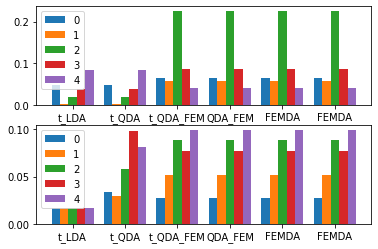

In [77]:
evaluate_all(list(models_vis_mislabelling_contamination.values())[2:], means_synth2, covs_synth2)

#### Pre-Normalised dataset with test contamination

In [78]:
X_2d_n = normalise_centered(X_2d, y_2d)

With outlier rejection
LDA
Fitting time 0.0
N 500 Accuracy 0.742 ARI 0.47527 AMI 0.46606
QDA
Fitting time 0.0
N 500 Accuracy 0.754 ARI 0.48446 AMI 0.47941
t-LDA
Fitting time 1.1178181171417236
N 500 Accuracy 0.736 ARI 0.46719 AMI 0.45708
t-QDA
Fitting time 1.0339224338531494
N 500 Accuracy 0.738 ARI 0.47063 AMI 0.46322
t-QDA-FEM
Fitting time 0.7322719097137451
N 500 Accuracy 0.72 ARI 0.40492 AMI 0.42597
QDA-FEM
Fitting time 0.03776192665100098
N 500 Accuracy 0.76 ARI 0.48572 AMI 0.48102
FEMDA
Fitting time 0.04684948921203613
N 500 Accuracy 0.678 ARI 0.41559 AMI 0.42059
FEMDA with naive scatter constant
Fitting time 0.06281137466430664
N 500 Accuracy 0.71 ARI 0.41801 AMI 0.41201
FEMDA test
Fitting time 0.06852960586547852
N 500 Accuracy 0.728 ARI 0.43991 AMI 0.43837


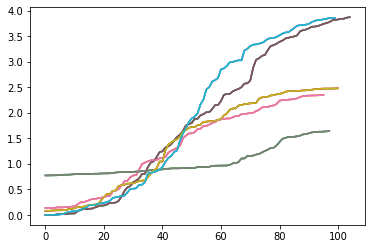

In [79]:
print("With outlier rejection")
models_vis_mislabelling_contamination_n = run_all(X_2d_n,y_2d,X_test_c_2d,y_test_c_2d, percent_outliers=0.1)

In [80]:
print("Without outlier rejection")
test_all(models_vis_mislabelling_contamination_n,X_test_c_2d,y_test_c_2d_clean, percent_outliers=0)

Without outlier rejection
LDA
N 500 Accuracy 0.74 ARI 0.46689 AMI 0.46341
QDA
N 500 Accuracy 0.746 ARI 0.47426 AMI 0.47198
t_LDA
N 500 Accuracy 0.742 ARI 0.47059 AMI 0.46689
t_QDA
N 500 Accuracy 0.75 ARI 0.48108 AMI 0.47635
t_QDA_FEM
N 500 Accuracy 0.736 ARI 0.45541 AMI 0.489
QDA_FEM
N 500 Accuracy 0.75 ARI 0.47792 AMI 0.47186
FEMDA
N 500 Accuracy 0.696 ARI 0.39356 AMI 0.42546
FEMDA
N 500 Accuracy 0.724 ARI 0.43769 AMI 0.43221


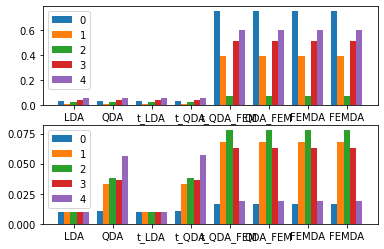

In [81]:
evaluate_all(models_vis_mislabelling_contamination_n, means_synth2, covs_synth2)

## Synthetic data setup 3

In [34]:
p=10
means_synth3 = {2: np.zeros((p)), 0: -20*np.ones((p)), 1: 20*np.ones((p))}
covs_synth3 = {2: toeplitz(0.4, p), 0: np.eye(p), 1:toeplitz(0.7, p)} #{2: np.eye(p), 0: np.eye(p), 1: np.eye(p)}

In [35]:
def synthesise3(n, contamination=0, mislabelling=0): #contamination, mislabelling percent
    hard = True
    X1a = LaplacesDemon.rmvpe(n, mu=means_synth3[0], Sigma=covs_synth3[0], kappa=0.1) #Generalised Gaussian
    o1a = np.zeros((n))>0
    X1b,o1b = contaminated(n, stats.multivariate_t, contamination, loc=means_synth3[0], shape=covs_synth3[0], df=20, hard=hard) # Gaussian
    X1 = combine_dataset(X1a,X1b,0)
    o1 = combine_dataset(o1a, o1b, 0)
    
    X2a = LaplacesDemon.rmvpe(n, mu=means_synth3[1], Sigma=covs_synth3[1], kappa=0.1) #Generalised Gaussian
    o2a =np.zeros((n))>0
    X2b,o2b = contaminated(n, stats.multivariate_t, contamination, loc=means_synth3[1], shape=covs_synth3[1], df=1, hard=hard) #Gaussian
    X2 = combine_dataset(X2a,X2b,0)
    o2 = combine_dataset(o1a, o1b, 0)
    
    #X2 = contaminated(n, stats.multivariate_t, contamination, loc=, shape=, df=2.3, hard=hard) #t
    
    X3,o3 = contaminated(n, stats.multivariate_t, contamination, loc=means_synth3[2], shape=covs_synth3[2], df=1.5, hard=hard) #t
    
    y = mislabelled(n, mislabelling, np.arange(3))
    #print(y)
    return np.vstack([X1, X2, X3]), y, apply_outlierness([o1,o2,o3], y)

In [142]:
test_X,_= contaminated(1000, stats.multivariate_t, 0, loc=np.zeros((2)), shape=np.eye(2), df=20, hard=True) # Gaussian
test_X2,_= contaminated(1000, stats.multivariate_t, 0.5, loc=np.zeros((2)), shape=np.eye(2), df=20, hard=True) # Gaussian
bins = np.linspace(-20,20,100)

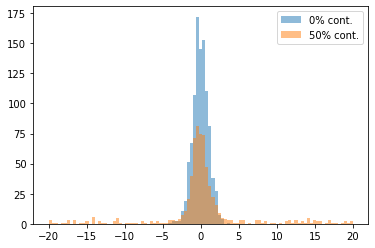

In [143]:
plt.hist(test_X[:,0], bins=bins, alpha=0.5, label='0% cont.')
plt.hist(test_X2[:,0], bins=bins, alpha=0.5, label='50% cont.')
plt.legend()
plt.savefig('setup1_histograms.pdf', bbox_inches = 'tight',pad_inches = 0.02)

### Run all experiments

In [38]:
result_book3 = np.zeros((6,6,10)) #5 algos, 4 measures, 10 runs
#result_book3_n = np.zeros((6,4,10))

for i in range(10):
    #get datasets
    c = 0.5
    X3,y3,_ = synthesise3(1000, contamination=c, mislabelling=0.05)
    X3_test,y3_test_clean,y3_test = synthesise3(500, contamination=c) #compare with known outliers

    #get models
    models, result_book3[:,:4,i] = run_all(X3,y3,X3_test,y3_test_clean, percent_outliers=0, conf=False, verbose=True, return_results=True)

    #evaluate estimators
    result_book3[:, 4:, i] = evaluate_all(models, means_synth3, covs_synth3, plot=False,ret=True)
    
    #test on normalisation
    #X3_n = normalise_centered(X3, y3)
    #models_n, result_book3_n[:,:,i] = run_all(X3_n,y3,X3_test,y3_test_clean, percent_outliers=0, conf=False, verbose=True, return_results=True)


LDA
N 1500 Accuracy 0.55133 ARI 0.20854 AMI 0.18015
QDA
N 1500 Accuracy 0.36667 ARI 0.00282 AMI 0.0214
RQDA-MCD
estimating...
estimating...
estimating...
N 1500 Accuracy 0.67867 ARI 0.268 AMI 0.31113
RGQDA-MCD
estimating...
estimating...
estimating...
optimal c is 0.6182982835714094
N 1500 Accuracy 0.68133 ARI 0.27371 AMI 0.31619
t-QDA
N 1500 Accuracy 0.792 ARI 0.47746 AMI 0.46697
FEMDA with p/trace
N 1500 Accuracy 0.82733 ARI 0.56036 AMI 0.50292
LDA
N 1500 Accuracy 0.614 ARI 0.19938 AMI 0.17518
QDA
N 1500 Accuracy 0.38333 ARI 0.00712 AMI 0.02747
RQDA-MCD
estimating...
estimating...
estimating...
N 1500 Accuracy 0.67667 ARI 0.27014 AMI 0.32281
RGQDA-MCD
estimating...
estimating...
estimating...
optimal c is 0.2635664393022567
N 1500 Accuracy 0.676 ARI 0.26693 AMI 0.32948
t-QDA
N 1500 Accuracy 0.80667 ARI 0.50899 AMI 0.49125
FEMDA with p/trace
N 1500 Accuracy 0.84133 ARI 0.59067 AMI 0.53072
LDA
N 1500 Accuracy 0.53933 ARI 0.18176 AMI 0.1569
QDA
N 1500 Accuracy 0.374 ARI 0.00414 AMI 0.01

In [43]:
%store result_book3

Stored 'result_book3' (ndarray)


In [41]:
%store result_book3_50

Stored 'result_book3_50' (ndarray)


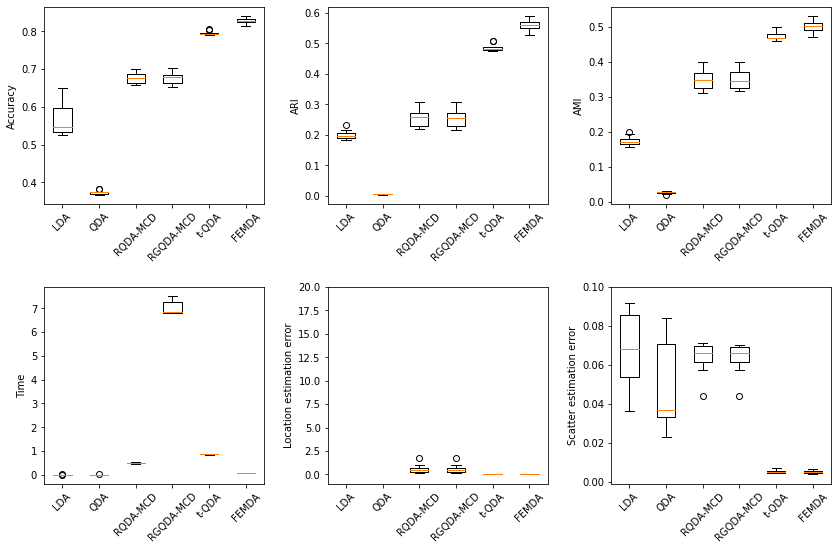

In [114]:
fig,extents=box_plot(result_book3_50, algos=["LDA","QDA","RQDA-MCD","RGQDA-MCD","t-QDA","FEMDA"], measures=["Time", "Accuracy", "ARI", "AMI", "Location estimation error", "Scatter estimation error"], e_loc_lims=[-1,20], e_sc_lims=[-0.001, 0.1])

In [115]:
save_subplots('results_synth3_50', fig, extents, ext='pdf')

### Contaminated Datasets

In [37]:
c = 0

In [38]:
X3,y3,_ = synthesise3(1000, contamination=c, mislabelling=0.05) #don't know outliers

In [39]:
X3_test,y3_test_clean,y3_test = synthesise3(500, contamination=c) #compare with known outliers

In [270]:
em = pd.DataFrame(umap.UMAP(metric='euclidean').fit_transform(X3), columns=['A','B']) 
em['label'] = pd.Series(y3).astype(str)
gg = ggplot(aes(x='A', y='B', color='label'), data=em)+geom_point()+ scale_color_discrete(guide=False)+ labs(x = "", y = "") 
#gg.save("MNIST38_real.png",dpi =300)

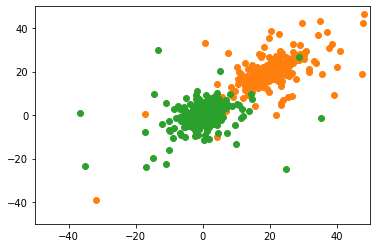

In [339]:
_,ax = plt.subplots()
plot_dataset(X3, y3, ax, lims=[[-50,50],[-50,50]])

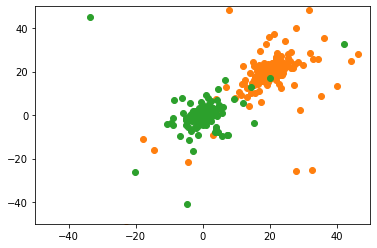

In [340]:
_,ax = plt.subplots()
plot_dataset(X3_test, y3_test_clean, ax, lims=[[-50,50],[-50,50]])

### Dataset with test contamination

In [40]:
print("With outlier rejection")
models_synth3 = run_all(X3,y3,X3_test,y3_test, percent_outliers=0.5)

With outlier rejection
LDA
N 1500 Accuracy 0.668 ARI 0.24934 AMI 0.46851
QDA
N 1500 Accuracy 0.78667 ARI 0.44526 AMI 0.5604
t-QDA
N 1500 Accuracy 0.66533 ARI 0.24979 AMI 0.46887
FEMDA with p/trace
N 1500 Accuracy 0.664 ARI 0.24918 AMI 0.46845


In [41]:
print("Without outlier rejection")
test_all(list(models_synth3.values()), X3_test, y3_test_clean, percent_outliers=0)

Without outlier rejection
LDA
N 1500 Accuracy 0.97867 ARI 0.9371 AMI 0.90073
QDA
N 1500 Accuracy 0.746 ARI 0.52564 AMI 0.59637
t_QDA
N 1500 Accuracy 0.99533 ARI 0.98608 AMI 0.97586
FEMDA
N 1500 Accuracy 0.99133 ARI 0.97422 AMI 0.95705


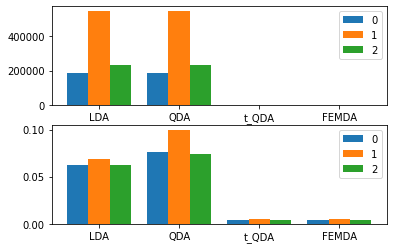

In [419]:
evaluate_all(list(models_synth3.values()), means_synth3, covs_synth3)

#### Pre-Normalised dataset with test contamination

In [188]:
X3_n = normalise_centered(X3, y3)

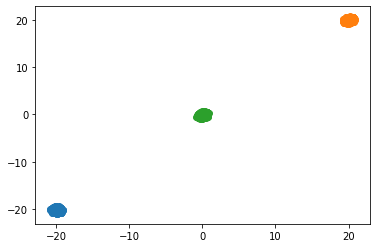

In [189]:
_,ax = plt.subplots()
plot_dataset(X3_n, y3, ax)

In [191]:
print("With outlier rejection")
models_synth3_n = run_all(X3_n,y3,X3_test,y3_test, percent_outliers=0.05)

With outlier rejection
LDA
N 1500 Accuracy 0.56733 ARI 0.41415 AMI 0.50335
QDA
N 1500 Accuracy 0.566 ARI 0.40797 AMI 0.49957
t-QDA
N 1500 Accuracy 0.52933 ARI 0.2747 AMI 0.42534
t-QDA-FEM
N 1500 Accuracy 0.578 ARI 0.13783 AMI 0.27722
FEMDA with p/trace
N 1500 Accuracy 0.694 ARI 0.2338 AMI 0.45248


In [192]:
print("Without outlier rejection")
test_all(models_synth3_n, X3_test, y3_test_clean, percent_outliers=0)

Without outlier rejection
LDA
N 1500 Accuracy 0.66667 ARI 0.22385 AMI 0.41295
QDA
N 1500 Accuracy 0.66267 ARI 0.21845 AMI 0.40874
t_QDA
N 1500 Accuracy 0.70733 ARI 0.30622 AMI 0.33863
t_QDA_FEM
N 1500 Accuracy 0.50867 ARI 0.05558 AMI 0.19287
FEMDA
N 1500 Accuracy 0.884 ARI 0.68517 AMI 0.61849


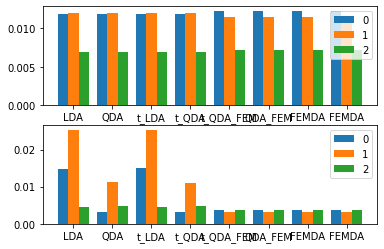

In [93]:
evaluate_all(models_synth3_n, means_synth3, covs_synth3)

## Synthetic data setup 4

In [28]:
mnist_pca, mnist_labels, mnist_raw, ve, pca = import_subset(mnist_data, mnist_labels_raw, selected_digits,30, 800)
mnist_test_pca, mnist_test_labels, mnist_test_raw,_,_2 = import_subset(mnist_test_data, mnist_test_labels_raw, selected_digits, 30, 400, pca=pca)

In [29]:
models_MNIST_pure = run_all(mnist_pca, mnist_labels, mnist_test_pca, mnist_test_labels)

LDA
N 4000 Accuracy 0.77575 ARI 0.60419 AMI 0.67994
QDA
N 4000 Accuracy 0.799 ARI 0.64043 AMI 0.70708
RQDA-MCD
estimating...
estimating...
estimating...
estimating...
estimating...
estimating...
estimating...
estimating...
estimating...
estimating...
N 4000 Accuracy 0.66075 ARI 0.42621 AMI 0.56831
RGQDA-MCD
estimating...
estimating...
estimating...
estimating...
estimating...
estimating...
estimating...
estimating...
estimating...
estimating...
optimal c is 0.0
N 4000 Accuracy 0.63575 ARI 0.40766 AMI 0.56315
t-QDA
N 4000 Accuracy 0.7935 ARI 0.62484 AMI 0.69189
FEMDA with p/trace
N 4000 Accuracy 0.79025 ARI 0.61828 AMI 0.68786


In [30]:
p=30
means_synth4 = dict((k,v) for k,v in enumerate(models_MNIST_pure["t_QDA"].means.T))
covs_synth4 = dict((k,v) for k,v in enumerate(models_MNIST_pure["t_QDA"].covariances))

In [31]:
def synthesise4(n, contamination=0, mislabelling=0, hard=False): #contamination, mislabelling percent
    def mixture(n_k, mean, cov, mix=0.3, kappa=0.2, df=20, hard=hard):
        Xa = LaplacesDemon.rmvpe(n_k, mu=mean, Sigma=cov, kappa=kappa) #Generalised Gaussian
        oa = np.zeros((n_k))>0
        Xb,ob = contaminated(n_k, stats.multivariate_t, contamination, loc=mean, shape=cov, df=df, hard=hard) # Gaussian
        X = combine_dataset(Xa,Xb,mix)
        o = combine_dataset(oa, ob,mix)
        return X,o
    mix = 0.8
    df = 20
    X1,o1 = mixture(n, means_synth4[0], covs_synth4[0], mix=mix, kappa=0.1, df=df)
    X2,o2 = mixture(n, means_synth4[1], covs_synth4[1], mix=mix, kappa=0.1, df=df)
    X3,o3 = mixture(n, means_synth4[2], covs_synth4[2], mix=mix, kappa=0.1, df=df)
    X4,o4 = mixture(n, means_synth4[3], covs_synth4[3], mix=mix, kappa=0.1, df=df)
    X5,o5 = mixture(n, means_synth4[4], covs_synth4[4], mix=mix, kappa=0.1, df=df)
    X6,o6 = mixture(n, means_synth4[5], covs_synth4[5], mix=mix, kappa=0.1, df=df)
    X7,o7 = mixture(n, means_synth4[6], covs_synth4[6], mix=mix, kappa=0.1, df=df)
    X8,o8 = mixture(n, means_synth4[7], covs_synth4[7], mix=mix, kappa=0.1, df=df)
    X9,o9 = mixture(n, means_synth4[8], covs_synth4[8], mix=mix, kappa=0.1, df=df)
    X10,o10 = mixture(n, means_synth4[9], covs_synth4[9], mix=mix, kappa=0.1, df=df)
    
    
    y = mislabelled(n, mislabelling, np.arange(10))
    #print(y)
    return np.vstack([X1, X2, X3, X4, X5, X6,X7,X8,X9,X10]), y, apply_outlierness([o1,o2,o3,o4,o5,o6,o7,o8,o9,o10], y)

In [135]:
test_X = LaplacesDemon.rmvpe(1000, mu=np.array([0,0]), Sigma=np.array([[1,0],[0,1]]), kappa=0.1)

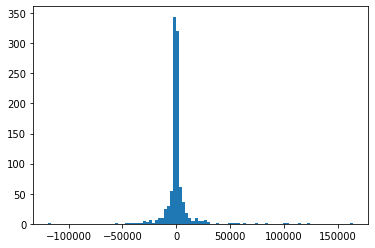

In [140]:
plt.hist(test_X[:,0], bins=100)
plt.savefig('setup2_histogram.pdf', bbox_inches = 'tight',pad_inches = 0.02)

### Run full experiment

In [32]:
result_book4 = np.zeros((6,6,10)) #5 algos, 4 measures, 10 runs
result_book4_n = np.zeros((6,4,10))

for i in range(10):
    #get datasets
    X4,y4,_ = synthesise4(1000, contamination=0, mislabelling=0)  
    X4_test,y4_test_clean,y4_test = synthesise4(500, contamination=0)

    #get models
    models, result_book4[:,:4,i] = run_all(X4,y4,X4_test,y4_test_clean, percent_outliers=0, conf=False, verbose=True, return_results=True)

    #evaluate estimators
    result_book4[:, 4:, i] = evaluate_all(models, means_synth4, covs_synth4, plot=False,ret=True)
    
    #test on normalisation
    #X4_n = normalise_centered(X4, y4)
    #models_n, result_book4_n[:,:,i] = run_all(X4_n,y4,X4_test,y4_test_clean, percent_outliers=0, conf=False, verbose=True, return_results=True)


LDA
N 5000 Accuracy 0.1 ARI 0.0 AMI 0.0
QDA
N 5000 Accuracy 0.1702 ARI 0.01456 AMI 0.07184
RQDA-MCD
estimating...
estimating...
estimating...
estimating...
estimating...
estimating...
estimating...
estimating...
estimating...
estimating...
N 5000 Accuracy 0.1 ARI 0.0 AMI 0.0
RGQDA-MCD
estimating...
estimating...
estimating...
estimating...
estimating...
estimating...
estimating...
estimating...
estimating...
estimating...
optimal c is 0.0
N 5000 Accuracy 0.1 ARI 0.0 AMI 0.0
t-QDA
N 5000 Accuracy 0.2936 ARI 0.01382 AMI 0.27155
FEMDA with p/trace
N 5000 Accuracy 0.9822 ARI 0.96187 AMI 0.96325
LDA
N 5000 Accuracy 0.1 ARI 0.0 AMI 0.0
QDA
N 5000 Accuracy 0.1698 ARI 0.01432 AMI 0.07194
RQDA-MCD
estimating...
estimating...
estimating...
estimating...
estimating...
estimating...
estimating...
estimating...
estimating...
estimating...
N 5000 Accuracy 0.1 ARI 0.0 AMI 0.0
RGQDA-MCD
estimating...
estimating...
estimating...
estimating...
estimating...
estimating...
estimating...
estimating...
esti

In [33]:
%store result_book4

Stored 'result_book4' (ndarray)


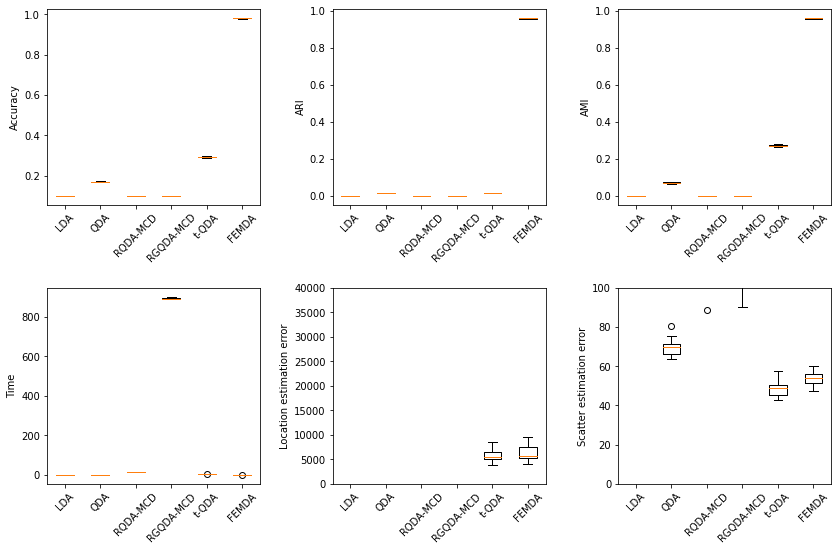

In [116]:
fig,extents=box_plot(result_book4, algos=["LDA","QDA","RQDA-MCD","RGQDA-MCD","t-QDA", "FEMDA"], measures=["Time", "Accuracy", "ARI", "AMI", "Location estimation error", "Scatter estimation error"], e_loc_lims=[-1,4e4], e_sc_lims=[-0.001, 100])

In [117]:
save_subplots('results_synth4', fig, extents, ext='pdf')

### Contaminated datasets

In [11]:
X4,y4,_ = synthesise4(1000, contamination=0, mislabelling=0, hard=True) #don't know outliers

In [12]:
rqdastest = RGQDA('MCD')
st = time.time()
rqdastest.fit(X4, pd.Series(y4), c=1)
print(time.time()-st )

estimating...
estimating...
estimating...
estimating...
estimating...
estimating...
estimating...
estimating...
estimating...
estimating...
15.093296527862549


In [33]:
X4_test,y4_test_clean,y4_test = synthesise4(500, contamination=0, hard=True) #compare with known outliers

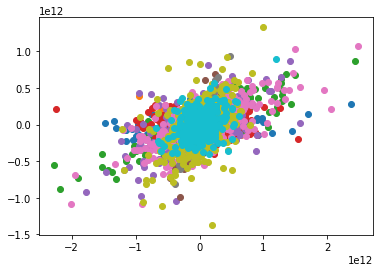

In [34]:
_,ax = plt.subplots()
plot_dataset(X4_test, y4_test_clean, ax)

In [22]:
print("With outlier rejection")
models_synth4 = run_all(X4,y4,X4_test,y4_test, percent_outliers=0)

With outlier rejection


NameError: name 'X4' is not defined

In [ ]:
print("Without outlier rejection")
test_all(models_synth4,X4_test,y4_test_clean, percent_outliers=0)

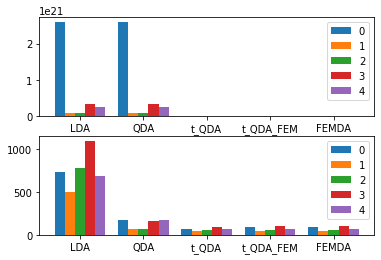

In [68]:
evaluate_all(list(models_synth4.values()), means_synth4, covs_synth4)

femdatest = FEMDA()
femdatest.fit(X4, pd.Series(y4))
print_metrics(pd.Series(y4_test_clean), femdatest.predict(X4_test), conf=True)

#### Pre-Normalised

In [102]:
X4_n = normalise_centered(X4, y4)

With outlier rejection
LDA
Fitting time 0.031245946884155273
N 2500 Accuracy 0.2512 ARI -0.00127 AMI 0.00598
[[  0 125   0   0   0   0]
 [ 17 458   0   0   0   0]
 [ 43 432   0   0   0   0]
 [ 21 454   0   0   0   0]
 [ 29 446   0   0   0   0]
 [ 15 460   0   0   0   0]]
QDA
Fitting time 0.0
N 2500 Accuracy 0.2564 ARI 0.00043 AMI 0.02753
[[  0 125   0   0   0   0]
 [  0 475   0   0   0   0]
 [ 57 418   0   0   0   0]
 [  6 469   0   0   0   0]
 [ 46 429   0   0   0   0]
 [ 16 459   0   0   0   0]]
t-LDA
Fitting time 1.633171558380127
N 2500 Accuracy 0.2552 ARI -0.0016 AMI 0.02221
[[  0 125   0   0   0   0]
 [ 16 459   0   0   0   0]
 [ 43 417  10   0   0   5]
 [ 18 448   0   9   0   0]
 [ 30 426   9   0   0  10]
 [ 17 447   0   0   0  11]]
t-QDA
Fitting time 1.7355968952178955
N 2500 Accuracy 0.4992 ARI 0.20191 AMI 0.32621
[[  0  35  32  20   1  37]
 [  0 475   0   0   0   0]
 [ 23 115 309   0   0  28]
 [ 29 344   0 102   0   0]
 [ 58 153 103   0  13 148]
 [ 12 162   1   0   0 300]]
t-

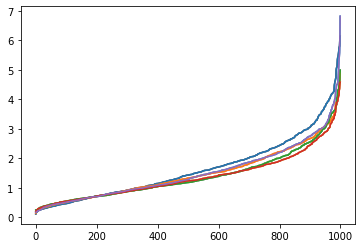

In [182]:
print("With outlier rejection")
models_synth4_n = run_all(X4_n,y4,X4_test,y4_test, percent_outliers=0.05, conf=True)

In [196]:
print("Without outlier rejection")
test_all(models_synth4_n, X4_test, y4_test_clean, percent_outliers=0)

Without outlier rejection
LDA
N 2500 Accuracy 0.2 ARI 0.0 AMI 0.0
QDA
N 2500 Accuracy 0.2 ARI 0.0 AMI 0.0
t_LDA
N 2500 Accuracy 0.2192 ARI 0.00035 AMI 0.02617
t_QDA
N 2500 Accuracy 0.3144 ARI 0.0129 AMI 0.14877
t_QDA_FEM
N 2500 Accuracy 0.3212 ARI 0.0135 AMI 0.15611
QDA_FEM
N 2500 Accuracy 0.2 ARI 0.0 AMI 0.0
FEMDA
N 2500 Accuracy 0.9692 ARI 0.92539 AMI 0.90573
FEMDA
N 2500 Accuracy 0.9692 ARI 0.92539 AMI 0.90573
FEMDA
N 2500 Accuracy 0.9692 ARI 0.92539 AMI 0.90573


## Test

In [105]:
means_synth5 = {0: np.array([20 , 20]), 1: np.array([-20, 20]), 2: np.array([20 ,-20]), 3: np.array([-20,-20])}
covs_synth5 = {0: np.eye(2), 1: np.eye(2), 2: np.eye(2), 3: np.eye(2)}

In [106]:
def synthesise5(n, contamination=0, mislabelling=0): #contamination, mislabelling percent
    hard = False
    X1,o1 = contaminated(n, stats.multivariate_t, contamination, loc=means_synth5[0], shape=covs_synth5[0], df=20, hard=hard) #cauchy
    X2,o2 = contaminated(n, stats.multivariate_t, contamination, loc=means_synth5[1], shape=covs_synth5[1], df=20, hard=hard) #t
    X3,o3 = contaminated(n, stats.multivariate_t, contamination, loc=means_synth5[2], shape=covs_synth5[2], df=20, hard=hard) #normal
    X4,o4 = contaminated(n, stats.multivariate_t, contamination, loc=means_synth5[3], shape=covs_synth5[3], df=20, hard=hard) #cauchy
    #X5,o5 = contaminated(n, stats.multivariate_t, contamination, loc=means_synth5[4], shape=covs_synth5[4], df=20, hard=hard) #cauchy
    y = mislabelled(n, mislabelling, np.arange(4))
    return np.vstack([X1, X2, X3, X4]), y, apply_outlierness([o1,o2,o3,o4], y)

In [107]:
X_test_5,y_test_5,_ = synthesise5(100)

In [178]:
X_5,y_5,_ = synthesise5(100, contamination=0, mislabelling=0)

LDA
0.009977340698242188
N 400 Accuracy 1.0 ARI 1.0 AMI 1.0
QDA
0.0
N 400 Accuracy 1.0 ARI 1.0 AMI 1.0
t-LDA
0.8599307537078857
N 400 Accuracy 1.0 ARI 1.0 AMI 1.0
t-QDA
0.7996840476989746
N 400 Accuracy 1.0 ARI 1.0 AMI 1.0
t-QDA-FEM
0.10964751243591309
N 400 Accuracy 1.0 ARI 1.0 AMI 1.0
QDA-FEM
0.03995680809020996
N 400 Accuracy 1.0 ARI 1.0 AMI 1.0
FEMDA
0.04989886283874512
4
N 400 Accuracy 1.0 ARI 1.0 AMI 1.0
[[100   0   0   0]
 [  0 100   0   0]
 [  0   0 100   0]
 [  0   0   0 100]]
FEMDA with naive scatter constant
0.03020334243774414
4
N 400 Accuracy 1.0 ARI 1.0 AMI 1.0
[[100   0   0   0]
 [  0 100   0   0]
 [  0   0 100   0]
 [  0   0   0 100]]


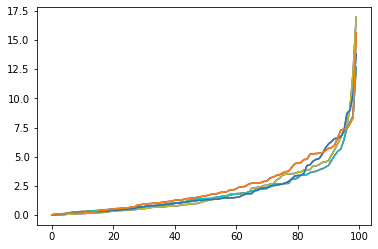

In [200]:
models_5 = run_all(X_5, y_5, X_test_5, y_test_5)

4
4
4
4


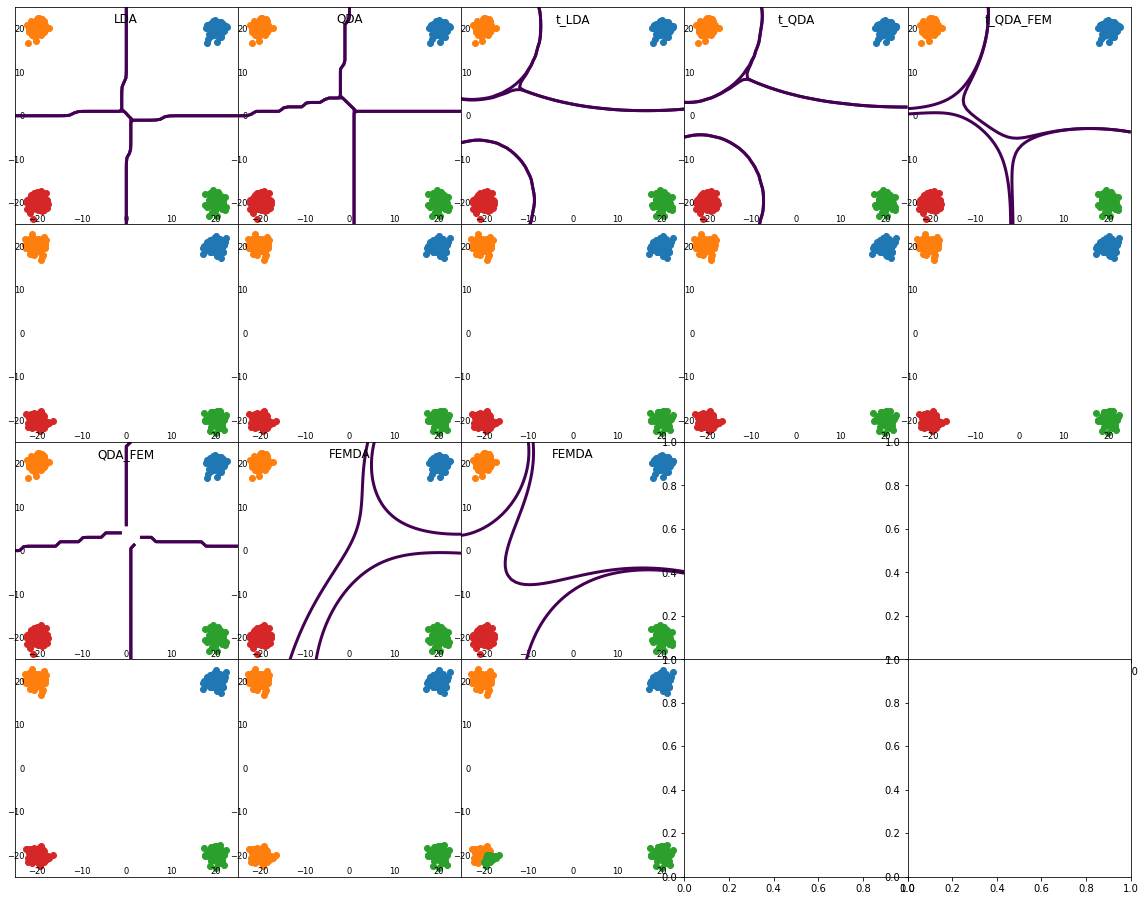

In [185]:
plot_models(X_5, y_5, X_test_5, models_5, lims=[[-25,25],[-25,25]])

## Statlog test

### Prepare Statlog data

In [21]:
read_statlog = pd.read_csv(r"data\statlog.csv")
statlog_labels = read_statlog.iloc[:, 0]
statlog_data = read_statlog.iloc[:, 1:]

In [22]:
# train test split
statlog_train, statlog_test, statlog_labels, statlog_test_labels = train_test_split(statlog_data, statlog_labels, test_size=0.33, random_state=43)
statlog_train = np.array(statlog_train); statlog_test = np.array(statlog_test); statlog_labels = np.array(statlog_labels); statlog_test_labels = np.array(statlog_test_labels); 

### Pure Statlog

In [23]:
models_statlog_pure = run_all(statlog_train, statlog_labels, statlog_test, statlog_test_labels)

LDA
N 228 Accuracy 0.67544 ARI 0.11933 AMI 0.09677
QDA
N 228 Accuracy 0.64035 ARI 0.07498 AMI 0.09041
t-QDA
N 228 Accuracy 0.75877 ARI 0.26463 AMI 0.19901
FEMDA with p/trace
N 228 Accuracy 0.74561 ARI 0.23797 AMI 0.17753


### Statlog with mislabelling

In [24]:
statlog_labels_mislabelled = flip_bits(statlog_labels, 0.1)

In [66]:
models_statlog_mislabelling = run_all(statlog_train, statlog_labels_mislabelled, statlog_test, statlog_test_labels)

LDA
N 228 Accuracy 0.72807 ARI 0.2019 AMI 0.1368
QDA
N 228 Accuracy 0.67982 ARI 0.11389 AMI 0.08945
t-QDA
N 228 Accuracy 0.72807 ARI 0.20314 AMI 0.13784
FEMDA with p/trace
N 228 Accuracy 0.71491 ARI 0.17979 AMI 0.12016


### Statlog with contamination

In [25]:
statlog_train_contaminated,_ = contaminate_dataset(statlog_train, 0.1)

In [74]:
models_statlog_contaminated = run_all(statlog_train_contaminated, statlog_labels, statlog_test, statlog_test_labels)

LDA
N 228 Accuracy 0.72368 ARI 0.19458 AMI 0.13062
QDA
N 228 Accuracy 0.58333 ARI 0.00254 AMI -0.00428
t-LDA
N 228 Accuracy 0.65789 ARI 0.09496 AMI 0.099
t-QDA
N 228 Accuracy 0.72807 ARI 0.20459 AMI 0.15293
RGQDA
optimal c is 0.0
N 228 Accuracy 0.65351 ARI 0.08797 AMI 0.11901
RGQDA-S
optimal c is 0.6243759205910031
N 228 Accuracy 0.64035 ARI 0.0746 AMI 0.05026
RQDA-M
N 228 Accuracy 0.7193 ARI 0.18479 AMI 0.12568
RQDA-S
N 228 Accuracy 0.64474 ARI 0.07947 AMI 0.05224
t-QDA-FEM
N 186 Accuracy 0.74731 ARI 0.2263 AMI 0.1338
QDA-FEM
N 225 Accuracy 0.6 ARI 0.0 AMI -0.0


### Statlog with contamination and mislabelling

In [26]:
models_statlog_contaminated_mislabelling = run_all(statlog_train_contaminated, statlog_labels_mislabelled, statlog_test, statlog_test_labels)

LDA
N 228 Accuracy 0.65789 ARI 0.09577 AMI 0.06834
QDA
N 228 Accuracy 0.54386 ARI 0.00391 AMI 0.01909
t-QDA
N 228 Accuracy 0.74561 ARI 0.23796 AMI 0.17792
FEMDA with p/trace
N 228 Accuracy 0.75 ARI 0.24669 AMI 0.1873


### Statlog with test contamination

In [28]:
statlog_test_contaminated,contam_ind = contaminate_dataset(statlog_test, 0.1)
statlog_test_labels_c = apply_outlierness(contam_ind, statlog_test_labels)

In [29]:
print("With outlier rejection")
test_all(models_statlog_contaminated_mislabelling, statlog_test_contaminated, statlog_test_labels_c, percent_outliers=0.1)

With outlier rejection
LDA
N 228 Accuracy 0.65789 ARI 0.19132 AMI 0.28113
QDA
N 228 Accuracy 0.57895 ARI 0.26921 AMI 0.35208
t_QDA
N 228 Accuracy 0.74123 ARI 0.28871 AMI 0.30918
FEMDA
N 228 Accuracy 0.73684 ARI 0.27581 AMI 0.28816


In [30]:
print("Without outlier rejection")
test_all(list(models_statlog_contaminated_mislabelling.values()), statlog_test_contaminated, statlog_test_labels, percent_outliers=0)

Without outlier rejection
LDA
N 228 Accuracy 0.64035 ARI 0.07424 AMI 0.04708
QDA
N 228 Accuracy 0.62281 ARI 0.03278 AMI 0.03621
t_QDA
N 228 Accuracy 0.72807 ARI 0.20314 AMI 0.13784
FEMDA
N 228 Accuracy 0.72368 ARI 0.19483 AMI 0.13094


#### Pre-Normalised

In [31]:
statlog_train_n = normalise_centered(statlog_train_contaminated, statlog_labels_mislabelled)

In [33]:
print("With outlier rejection")
models_statlog_n = run_all(statlog_train_n,statlog_labels_mislabelled,statlog_test,statlog_test_labels_c, percent_outliers=0.1)

With outlier rejection
LDA
N 228 Accuracy 0.61404 ARI 0.11087 AMI 0.09629
QDA
N 228 Accuracy 0.61404 ARI 0.0888 AMI 0.07325
t-QDA
N 228 Accuracy 0.62719 ARI 0.11805 AMI 0.22352
FEMDA with p/trace
N 228 Accuracy 0.75439 ARI 0.3167 AMI 0.34285


In [34]:
print("Without outlier rejection")
test_all(list(models_statlog_n.values()), statlog_test, statlog_test_labels, percent_outliers=0)

Without outlier rejection
LDA
N 228 Accuracy 0.59211 ARI 0.0 AMI 0.0
QDA
N 228 Accuracy 0.59211 ARI 0.0 AMI 0.0
t_QDA
N 228 Accuracy 0.58772 ARI 0.01651 AMI 0.12653
FEMDA
N 228 Accuracy 0.74561 ARI 0.23714 AMI 0.16617


## Phoneme data

In [50]:
read_phoneme_features = pd.read_csv(r"data\phonemedata_features.csv")
read_phoneme_labels = pd.read_csv(r"data\phonemedata_labels.csv")
phoneme_labels = read_phoneme_labels.iloc[:, 0]
phoneme_data = read_phoneme_features.iloc[:, :]

In [51]:
selected_digits = np.unique(phoneme_labels)
phoneme_pca, phoneme_labels_sel, phoneme_raw, ve, pca = import_subset(phoneme_data, phoneme_labels, selected_digits, -1, 695)

In [52]:
# train test split
# do import_subset directly here, because that creates balanced classes. -1 for no pca.
phoneme_train, phoneme_test, phoneme_labels, phoneme_test_labels = train_test_split(phoneme_pca, phoneme_labels_sel, test_size=0.3, random_state=43)
phoneme_train = np.array(phoneme_train); phoneme_test = np.array(phoneme_test); phoneme_labels = np.array(phoneme_labels); phoneme_test_labels = np.array(phoneme_test_labels); 

In [53]:
models_phoneme_pure = run_all(phoneme_train, phoneme_labels, phoneme_test, phoneme_test_labels)

LDA
N 1043 Accuracy 0.92234 ARI 0.84714 AMI 0.86492
QDA
N 1043 Accuracy 0.84756 ARI 0.72944 AMI 0.77141
t-QDA
N 1043 Accuracy 0.77181 ARI 0.58759 AMI 0.69024
FEMDA with p/trace
N 1043 Accuracy 0.85427 ARI 0.73957 AMI 0.76875


In [54]:
phoneme_labels_mislabelled = mislabelled_irregular(phoneme_labels, 0.1)

In [55]:
phoneme_train_contaminated,_ = contaminate_dataset(phoneme_train, 0.1)

In [56]:
models_phoneme_contaminated_mislabelled = run_all(phoneme_train_contaminated, phoneme_labels_mislabelled, phoneme_test, phoneme_test_labels, conf=True)

LDA
QDA
t-QDA
N 1043 Accuracy 0.70374 ARI 0.44461 AMI 0.46742
[[123  30   2  22   2]
 [ 84 104   5  13   7]
 [ 18   7 150  22  38]
 [ 27   2   8 159   5]
 [  2   0  12   3 198]]
FEMDA with p/trace
N 1043 Accuracy 0.52349 ARI 0.25451 AMI 0.33849
[[152  10   0  14   3]
 [148  48   0  11   6]
 [105   2  11  57  60]
 [ 53   1   0 144   3]
 [ 16   0   0   8 191]]


In [57]:
phoneme_train_n = normalise_centered(phoneme_train, phoneme_labels)

In [58]:
models_phoneme_n = run_all(phoneme_train_n, phoneme_labels, phoneme_test, phoneme_test_labels)

LDA
N 1043 Accuracy 0.22531 ARI 0.0 AMI -0.0
QDA
N 1043 Accuracy 0.22531 ARI 0.0 AMI -0.0
t-QDA
N 1043 Accuracy 0.83701 ARI 0.70129 AMI 0.73541
FEMDA with p/trace
N 1043 Accuracy 0.83797 ARI 0.70373 AMI 0.73757


In [59]:
phoneme_train_c_n = normalise_centered(phoneme_train_contaminated, phoneme_labels)

In [60]:
models_phoneme_c_n = run_all(phoneme_train_c_n, phoneme_labels_mislabelled, phoneme_test, phoneme_test_labels)

LDA
N 1043 Accuracy 0.22531 ARI 0.0 AMI -0.0
QDA
N 1043 Accuracy 0.22531 ARI 0.0 AMI -0.0
t-QDA
N 1043 Accuracy 0.52157 ARI 0.21245 AMI 0.24672
FEMDA with p/trace
N 1043 Accuracy 0.52828 ARI 0.21192 AMI 0.24824


## 20newsgroups data

In [23]:
from sklearn.datasets import fetch_20newsgroups
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

categories = ['sci.space',
    'talk.religion.misc',
    'rec.motorcycles',
    'comp.windows.x']

dataset = fetch_20newsgroups(subset='all', categories=categories,
                             shuffle=True, random_state=44)

In [24]:
labels = dataset.target
true_k = np.unique(labels).shape[0]

vectorizer = TfidfVectorizer(max_df=0.5, max_features=150,
                                 min_df=2, stop_words='english')

X = vectorizer.fit_transform(dataset.data)

XXdata  = pd.DataFrame(X.toarray())

In [25]:
result_book_TNG2 = np.zeros((6,4,10)) #4 algos, 4 measures, 10 runs

for i in range(10):
    #get datasets
    news_pca, news_labels, news_raw, ve, _ = import_subset(XXdata, labels, [0,1,2,3], 100, 600)
    # train test split
    TNG_train, TNG_test, TNG_labels, TNG_test_labels = train_test_split(news_pca, news_labels, test_size=0.17, random_state=42)
    TNG_train = np.array(TNG_train); TNG_test = np.array(TNG_test); TNG_labels = np.array(TNG_labels); TNG_test_labels = np.array(TNG_test_labels); 
    
    
    TNG_train_contaminated,_ = contaminate_dataset(TNG_train, 0.1)
    TNG_test_contaminated,contam_ind = contaminate_dataset(TNG_test, 0.1)
    TNG_labels_mislabelled = mislabelled_irregular(TNG_labels, 0.1)
    
    #get models
    models, result_book_TNG2[:,:,i] = run_all(TNG_train_contaminated, TNG_labels_mislabelled, TNG_test_contaminated, TNG_test_labels, conf=False, verbose=True, return_results=True)
    
    #test on normalisation
    #mnist_pca_n = normalise_centered(mnist_pca_contaminated, mnist_labels_mislabelled)
    #models_n, result_book_MNIST_n[:,:,i] = run_all(mnist_pca_n, mnist_labels_mislabelled, mnist_test_pca_c, mnist_test_labels, conf=False, verbose=True, return_results=True)

LDA
N 409 Accuracy 0.27139 ARI -0.00028 AMI 0.00137
QDA
N 409 Accuracy 0.48655 ARI 0.12351 AMI 0.23182
RQDA-MCD
estimating...
estimating...
estimating...
estimating...
N 409 Accuracy 0.83863 ARI 0.61403 AMI 0.56714
RGQDA-MCD
estimating...
estimating...
estimating...
estimating...
optimal c is 0.0
N 409 Accuracy 0.8533 ARI 0.6449 AMI 0.59432
t-QDA
N 409 Accuracy 0.85086 ARI 0.64147 AMI 0.59638
FEMDA with p/trace
N 409 Accuracy 0.87286 ARI 0.69 AMI 0.64393
LDA
N 409 Accuracy 0.27139 ARI -3e-05 AMI 0.00625
QDA
N 409 Accuracy 0.60636 ARI 0.26668 AMI 0.32882
RQDA-MCD
estimating...
estimating...
estimating...
estimating...
N 409 Accuracy 0.81663 ARI 0.56904 AMI 0.5253
RGQDA-MCD
estimating...
estimating...
estimating...
estimating...
optimal c is 0.0
N 409 Accuracy 0.81663 ARI 0.56856 AMI 0.53281
t-QDA
N 409 Accuracy 0.8533 ARI 0.64473 AMI 0.59716
FEMDA with p/trace
N 409 Accuracy 0.86797 ARI 0.67735 AMI 0.62001
LDA
N 409 Accuracy 0.2665 ARI 0.00022 AMI -0.00224
QDA
N 409 Accuracy 0.59658 ARI

In [26]:
%store result_book_TNG2

Stored 'result_book_TNG2' (ndarray)


In [10]:
%store result_book_TNG

Stored 'result_book_TNG' (ndarray)


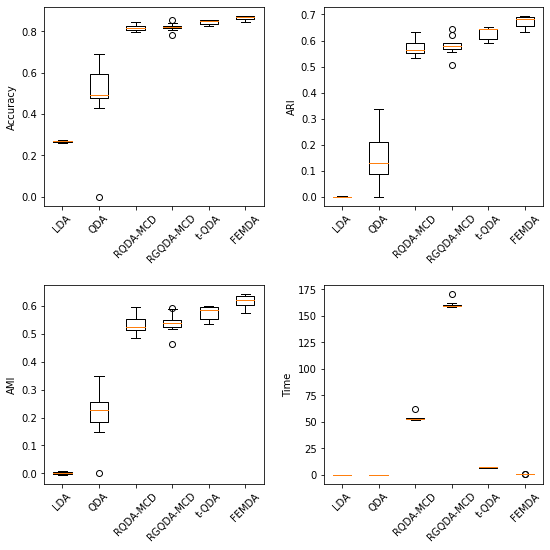

In [103]:
fig,extents=box_plot(result_book_TNG2, algos=["LDA","QDA","RQDA-MCD","RGQDA-MCD","t-QDA", "FEMDA"], measures=["Time", "Accuracy", "ARI", "AMI"])

In [105]:
save_subplots('results_TNG', fig, extents, ext='pdf')

## NORB test

### Prepare NORB data

In [79]:
from smallnorb import *

In [81]:
NORB = SmallNORBDataset(dataset_root='data/')

datiss = NORB._parse_NORB_dat_file('data/smallnorb-5x46789x9x18x6x2x96x96-training-dat.mat')
NORB_datos = np.reshape(datiss, (48600, 9216,)) #each image in a row
NORB_datos_lt = NORB_datos[::2, :] #only left image

NORB_labels_raw = NORB._parse_NORB_cat_file('data/smallnorb-5x46789x9x18x6x2x96x96-training-cat.mat')

Loading categories...: 100%|██████████| 24300/24300 [00:00<00:00, 1558600.88it/s]


In [82]:
NORB_datos_lt = pd.DataFrame(NORB_datos_lt)

In [84]:
result_book_NORB = np.zeros((4,4,10)) #4 algos, 4 measures, 10 runs

for i in range(10):
    #get datasets
    selected_cat = [1, 2, 3, 4]
    NORB_pca, NORB_labels_sel, NORB_raw, ve, _ = import_subset(NORB_datos_lt, NORB_labels_raw, selected_cat, 30, 400)
    # train test split
    NORB_train, NORB_test, NORB_labels, NORB_test_labels = train_test_split(NORB_pca, NORB_labels_sel, test_size=0.33, random_state=42)
    NORB_train = np.array(NORB_train); NORB_test = np.array(NORB_test); NORB_labels = np.array(NORB_labels); NORB_test_labels = np.array(NORB_test_labels); 
    
    
    NORB_train_contaminated,_ = contaminate_dataset(NORB_train, 0.1)
    NORB_test_contaminated,contam_ind = contaminate_dataset(NORB_test, 0.1)
    NORB_labels_mislabelled = mislabelled_irregular(NORB_labels, 0.1)
    
    #get models
    models, result_book_NORB[:,:,i] = run_all(NORB_train_contaminated, NORB_labels_mislabelled, NORB_test_contaminated, NORB_test_labels, conf=False, verbose=True, return_results=True)
    
    #test on normalisation
    #mnist_pca_n = normalise_centered(mnist_pca_contaminated, mnist_labels_mislabelled)
    #models_n, result_book_MNIST_n[:,:,i] = run_all(mnist_pca_n, mnist_labels_mislabelled, mnist_test_pca_c, mnist_test_labels, conf=False, verbose=True, return_results=True)

LDA
N 528 Accuracy 0.2803 ARI -0.00024 AMI 0.01106
QDA
t-QDA
N 528 Accuracy 0.9375 ARI 0.8448 AMI 0.81557
FEMDA with p/trace
N 528 Accuracy 0.9375 ARI 0.84433 AMI 0.81353
LDA
N 528 Accuracy 0.2803 ARI 0.00158 AMI 0.02736
QDA
t-QDA
N 528 Accuracy 0.92235 ARI 0.80836 AMI 0.77302
FEMDA with p/trace
N 528 Accuracy 0.92235 ARI 0.80836 AMI 0.77302
LDA
N 528 Accuracy 0.27083 ARI -0.00116 AMI 0.01967
QDA
N 528 Accuracy 0.27083 ARI -0.00116 AMI 0.01602
t-QDA
N 528 Accuracy 0.94697 ARI 0.86823 AMI 0.84299
FEMDA with p/trace
N 528 Accuracy 0.94508 ARI 0.86495 AMI 0.84105
LDA
N 528 Accuracy 0.27462 ARI -0.00143 AMI 0.00437
QDA
t-QDA
N 528 Accuracy 0.90341 ARI 0.77111 AMI 0.73666
FEMDA with p/trace
N 528 Accuracy 0.9072 ARI 0.77944 AMI 0.74464
LDA
N 528 Accuracy 0.27273 ARI -0.00107 AMI 0.00828
QDA
N 528 Accuracy 0.26894 ARI -0.00179 AMI 0.00197
t-QDA
N 528 Accuracy 0.92045 ARI 0.81263 AMI 0.78851
FEMDA with p/trace
N 528 Accuracy 0.91856 ARI 0.80762 AMI 0.78303
LDA
N 528 Accuracy 0.27462 ARI -0.00

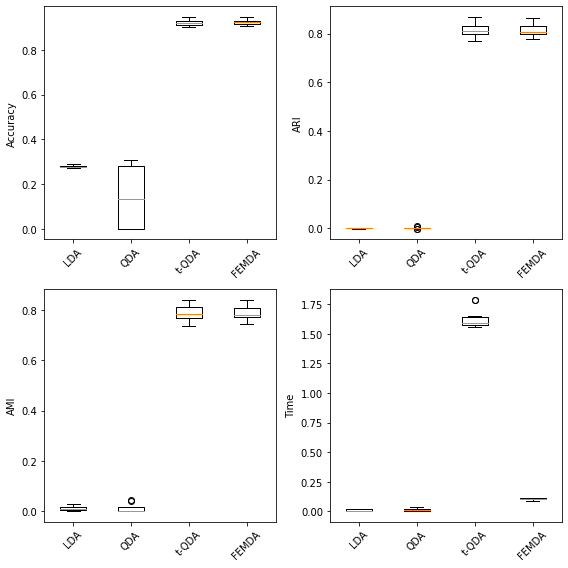

In [85]:
box_plot(result_book_NORB, algos=["LDA","QDA","t-QDA", "FEMDA"], measures=["Time", "Accuracy", "ARI", "AMI"])

In [198]:
np.random.seed(44)
random.seed(44)

#categories = ['human', 'airplane', 'truck', 'car']
selected_cat = [1, 2, 3, 4]
n_sample = 400
n_pca = 30

#NORB_norm = NORB_datos_lt - NORB_datos_lt.mean(axis=1).reshape(-1, 1) 


#NORB_datos_lt = pd.DataFrame(NORB_norm)

NORB_pca, NORB_labels_sel, NORB_raw, ve, _ = import_subset(NORB_datos_lt, NORB_labels_raw, selected_cat, 30, 400)

In [199]:
# train test split
NORB_train, NORB_test, NORB_labels, NORB_test_labels = train_test_split(NORB_pca, NORB_labels_sel, test_size=0.33, random_state=42)
NORB_train = np.array(NORB_train); NORB_test = np.array(NORB_test); NORB_labels = np.array(NORB_labels); NORB_test_labels = np.array(NORB_test_labels); 

In [ ]:
plt.tick_params(
    axis='both',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,   
    left=False,
    labelleft=False,
    labelbottom=False)
plt.imshow(np.reshape(1-np.array(NORB_raw.iloc[100])/255, (96, 96)), cmap="binary")

In [ ]:
norb_embedding = umap.UMAP(random_state = 44, metric='euclidean').fit_transform(NORB_pca)

norb_label = pd.Series(NORB_labels_sel)
norb_em = pd.DataFrame(norb_embedding, columns=['A','B']) 
norb_em['labels'] = norb_label.astype(str)
norb_gg = ggplot(aes(x='A', y='B', color='labels'), data=norb_em)+geom_point()+ylab("")+xlab("")+ scale_color_discrete(guide=False)
norb_gg

### Pure NORB test

LDA
Fitting time 0.0499725341796875
N 528 Accuracy 0.80114 ARI 0.56072 AMI 0.55591
QDA
Fitting time 0.007989883422851562
N 528 Accuracy 0.9072 ARI 0.78209 AMI 0.75595
t-LDA
Fitting time 2.510119676589966
N 528 Accuracy 0.78788 ARI 0.54133 AMI 0.52902
t-QDA
Fitting time 0.8176977634429932
N 528 Accuracy 0.91667 ARI 0.80098 AMI 0.76927
t-QDA-FEM
Fitting time 0.16276288032531738
N 528 Accuracy 0.90909 ARI 0.7872 AMI 0.75984
QDA-FEM
Fitting time 0.13804173469543457
N 528 Accuracy 0.88826 ARI 0.73177 AMI 0.70455
FEMDA with moyenne des maha
Fitting time 0.14713215827941895
N 528 Accuracy 0.9053 ARI 0.78027 AMI 0.7554
FEMDA with p/trace
Fitting time 0.13151025772094727
N 528 Accuracy 0.9053 ARI 0.78027 AMI 0.7554
FEMDA with 1/trace
Fitting time 0.10025262832641602
N 528 Accuracy 0.9053 ARI 0.78027 AMI 0.7554


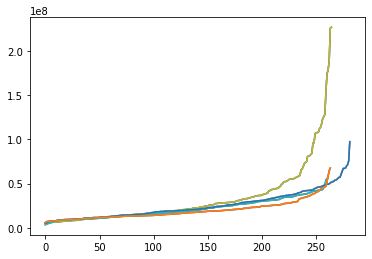

In [200]:
models_NORB_pure = run_all(NORB_train, NORB_labels, NORB_test, NORB_test_labels)

### NORB with train and test contamination

In [201]:
NORB_train_contaminated,_ = contaminate_dataset(NORB_train, 0.1)

LDA
Fitting time 0.031246662139892578
N 528 Accuracy 0.76136 ARI 0.49186 AMI 0.48783
QDA
Fitting time 0.015633106231689453
N 528 Accuracy 0.74432 ARI 0.4862 AMI 0.55467
t-LDA
Fitting time 1.959934949874878
N 528 Accuracy 0.78977 ARI 0.54317 AMI 0.53071
t-QDA
Fitting time 1.5763626098632812
N 528 Accuracy 0.90341 ARI 0.77484 AMI 0.74902
t-QDA-FEM
Fitting time 0.15369462966918945
N 528 Accuracy 0.9053 ARI 0.77915 AMI 0.75343
QDA-FEM
Fitting time 0.13151288032531738
N 528 Accuracy 0.88258 ARI 0.71946 AMI 0.6951
FEMDA with moyenne des maha
Fitting time 0.11588859558105469
N 528 Accuracy 0.90341 ARI 0.77484 AMI 0.74902
FEMDA with p/trace
Fitting time 0.10027289390563965
N 528 Accuracy 0.90341 ARI 0.77484 AMI 0.74902
FEMDA with 1/trace
Fitting time 0.11592364311218262
N 528 Accuracy 0.90341 ARI 0.77484 AMI 0.74902


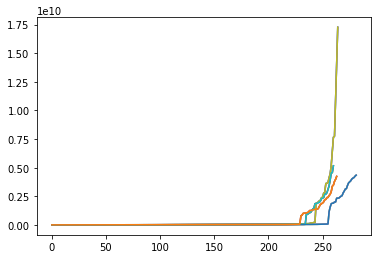

In [202]:
models_NORB_contaminated = run_all(NORB_train_contaminated, NORB_labels, NORB_test, NORB_test_labels)

In [203]:
NORB_test_contaminated,contam_ind = contaminate_dataset(NORB_test, 0.1)
NORB_test_labels_c = apply_outlierness(contam_ind, NORB_test_labels)

In [204]:
print("With outlier rejection")
test_all(models_NORB_contaminated, NORB_test_contaminated, NORB_test_labels_c, percent_outliers=0.1)

With outlier rejection
LDA
N 528 Accuracy 0.76515 ARI 0.50565 AMI 0.53355
QDA
N 528 Accuracy 0.77652 ARI 0.48264 AMI 0.5401
t_LDA
N 528 Accuracy 0.77652 ARI 0.52073 AMI 0.53134
t_QDA
N 528 Accuracy 0.90909 ARI 0.7816 AMI 0.77019
t_QDA_FEM
N 528 Accuracy 0.91098 ARI 0.7835 AMI 0.77354
QDA_FEM
N 528 Accuracy 0.78788 ARI 0.60222 AMI 0.59768
FEMDA
N 528 Accuracy 0.90909 ARI 0.78399 AMI 0.78085
FEMDA
N 528 Accuracy 0.90909 ARI 0.78399 AMI 0.78085
FEMDA
N 528 Accuracy 0.90909 ARI 0.78399 AMI 0.78085


In [205]:
print("Without outlier rejection")
test_all(models_NORB_contaminated, NORB_test_contaminated, NORB_test_labels, percent_outliers=0)

Without outlier rejection
LDA
N 528 Accuracy 0.75568 ARI 0.4848 AMI 0.47742
QDA
N 528 Accuracy 0.7197 ARI 0.43797 AMI 0.46242
t_LDA
N 528 Accuracy 0.77462 ARI 0.51628 AMI 0.50237
t_QDA
N 528 Accuracy 0.90152 ARI 0.77068 AMI 0.74371
t_QDA_FEM
N 528 Accuracy 0.89962 ARI 0.765 AMI 0.73408
QDA_FEM
N 528 Accuracy 0.81629 ARI 0.57276 AMI 0.54128
FEMDA
N 528 Accuracy 0.90152 ARI 0.7707 AMI 0.74503
FEMDA
N 528 Accuracy 0.90152 ARI 0.7707 AMI 0.74503
FEMDA
N 528 Accuracy 0.90152 ARI 0.7707 AMI 0.74503


#### Pre-Normalised

In [206]:
NORB_train_n = normalise_centered(NORB_train_contaminated, NORB_labels)

With outlier rejection
LDA
Fitting time 0.0156097412109375
N 528 Accuracy 0.33333 ARI 0.11009 AMI 0.33745
QDA
Fitting time 0.006508588790893555
N 528 Accuracy 0.33333 ARI 0.11009 AMI 0.33745
t-LDA
Fitting time 1.6041128635406494
N 528 Accuracy 0.43561 ARI 0.12738 AMI 0.24359
t-QDA
Fitting time 1.6664953231811523
N 528 Accuracy 0.86174 ARI 0.67085 AMI 0.69093
t-QDA-FEM
Fitting time 0.14713382720947266
N 528 Accuracy 0.86742 ARI 0.68369 AMI 0.69668
QDA-FEM
Fitting time 0.13150715827941895
N 528 Accuracy 0.33333 ARI 0.10646 AMI 0.31583
FEMDA with moyenne des maha
Fitting time 0.10025382041931152
N 528 Accuracy 0.9072 ARI 0.78054 AMI 0.77893
FEMDA with p/trace
Fitting time 0.08462357521057129
N 528 Accuracy 0.9072 ARI 0.78054 AMI 0.77893
FEMDA with 1/trace
Fitting time 0.11588072776794434
N 528 Accuracy 0.9072 ARI 0.78054 AMI 0.77893


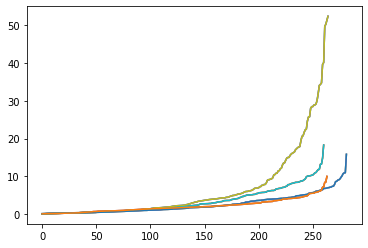

In [207]:
print("With outlier rejection")
models_NORB_n = run_all(NORB_train_n,NORB_labels,NORB_test_contaminated,NORB_test_labels_c, percent_outliers=0.1)

In [208]:
print("Without outlier rejection")
test_all(models_NORB_n, NORB_test_contaminated, NORB_test_labels, percent_outliers=0)

Without outlier rejection
LDA
N 528 Accuracy 0.26326 ARI 0.0 AMI 0.0
QDA
N 528 Accuracy 0.26326 ARI 0.0 AMI 0.0
t_LDA
N 528 Accuracy 0.39015 ARI 0.07405 AMI 0.14176
t_QDA
N 528 Accuracy 0.84091 ARI 0.63822 AMI 0.64257
t_QDA_FEM
N 528 Accuracy 0.85417 ARI 0.65665 AMI 0.65817
QDA_FEM
N 528 Accuracy 0.26326 ARI 0.0 AMI 0.0
FEMDA
N 528 Accuracy 0.89962 ARI 0.76731 AMI 0.74289
FEMDA
N 528 Accuracy 0.89962 ARI 0.76731 AMI 0.74289
FEMDA
N 528 Accuracy 0.89962 ARI 0.76731 AMI 0.74289
